In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML

from misc_util.logutils import setup_logging
from misc_util.pretty_print import Markdown, display

from derive_conceptualspace.pipeline import SnakeContext, load_envfiles
from derive_conceptualspace.util.result_analysis_tools import getfiles_allconfigs, display_metrics, show_lambda_elements, highlight_nonzero_max
from derive_conceptualspace.settings import DEFAULT_N_CPUS
from derive_conceptualspace.util.threadworker import WorkerPool

plt.rcParams['figure.figsize'] = [16, 10]

## Prepare all parameter-combinations

In [2]:
setup_logging()
load_envfiles("siddata")
configs, print_cnf = getfiles_allconfigs("clusters", verbose=True)

derive_conceptualspace/util/result_analysis_tools.py:26: UserWarning: There are files that won't be considered here: 
    siddata2022/de_debug_False/mfauhcsd2_onlyorig_minwords80/embedding_tfidf/mds_3d/all_count_quadratic/clusters_INTERRUPTED.json
    siddata2022/de_debug_False/mfauhcsd2_onlyorig_minwords80/embedding_tfidf/mds_3d/all_count_linear/clusters_INTERRUPTED.json
    siddata2022/de_debug_False/mfauhcsd2_onlyorig_minwords80/embedding_tfidf/mds_3d/all_tfidf_quadratic/clusters_INTERRUPTED.json
    siddata2022/de_debug_False/mfauhcsd2_onlyorig_minwords80/embedding_count/mds_3d/all_count_quadratic/clusters_INTERRUPTED.json
    siddata2022/de_debug_False/mfauhcsd2_onlyorig_minwords80/embedding_count/mds_3d/all_tfidf_linear/clusters_INTERRUPTED.json
    siddata2022/de_debug_False/mfauhcsd2_onlyorig_minwords80/embedding_count/mds_100d/all_tfidf_quadratic/clusters_INTERRUPTED.json
    siddata2022/de_debug_False/mfauhcsd2_onlyorig_minwords80/embedding_ppmi/mds_200d/all_count_linear/clus

<span style="font-size:11pt">There are 56 different parameter-combis for dataset <span style="color: #0000ff">siddata</span>:</span>

{'dataset': 'siddata2022',
 'language': 'de',
 'debug': 'False',
 'pp_components': ['mfauhcsd2', 'mfauhtcsldp'],
 'translate_policy': 'onlyorig',
 'min_words_per_desc': '80',
 'quantification_measure': ['count', 'ppmi', 'tfidf'],
 'embed_algo': 'mds',
 'embed_dimensions': ['3', '100', '200'],
 'extraction_method': 'all',
 'dcm_quant_measure': ['count', 'ppmi', 'tfidf'],
 'kappa_weights': ['linear', 'quadratic']}

# Showing all metrics for the loaded parameter-combinations

In [3]:
# for conf in configs:
#     specials = {k: v for k, v in conf.items() if isinstance(print_cnf[k], list)}
#     display(Markdown("## "+", ".join(f"{k}: {v}" for k,v in specials.items())))
#     ctx = SnakeContext.loader_context(config=conf, silent=True)
#     clusters = ctx.load("clusters")
#     #show_metrics(clusters)
#     display(generate_comparertable(clusters["metrics"], minval=0.1))
#     #look at combis o'f bin2bin, f_one, k_r2r+_min, k_dig+_2, k_c2r+

In [4]:
with WorkerPool(DEFAULT_N_CPUS-1, pgbar="Fetching clusters..") as pool:
    get_clusters = lambda conf: ((ctx := SnakeContext.loader_context(config=conf, silent=True)).get_important_settings(), ctx.load("clusters"))
    cluster_list, interrupted = pool.work(configs, get_clusters)

Fetching clusters.. [5 procs]: 100%|██████████| 56/56 [10:38<00:00, 11.40s/it]


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 3, dcm_quant_measure: count, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #00ffff">870eda1ce5</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

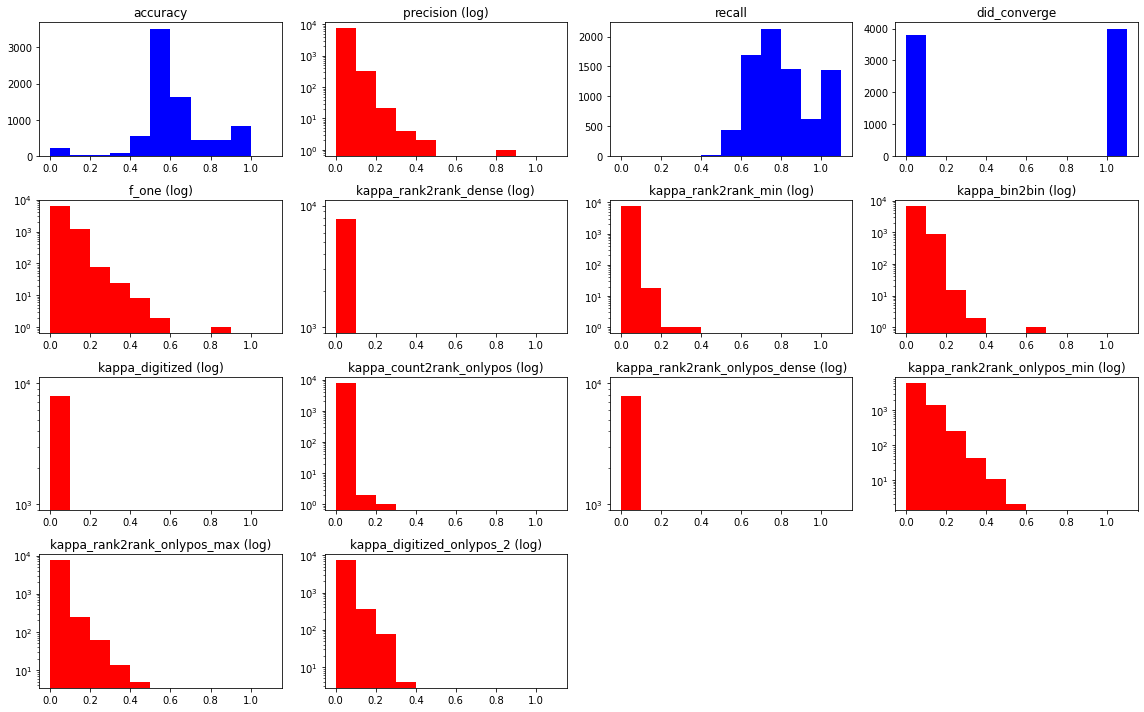

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 3, dcm_quant_measure: count, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #0000ff">ff5a71f47f</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

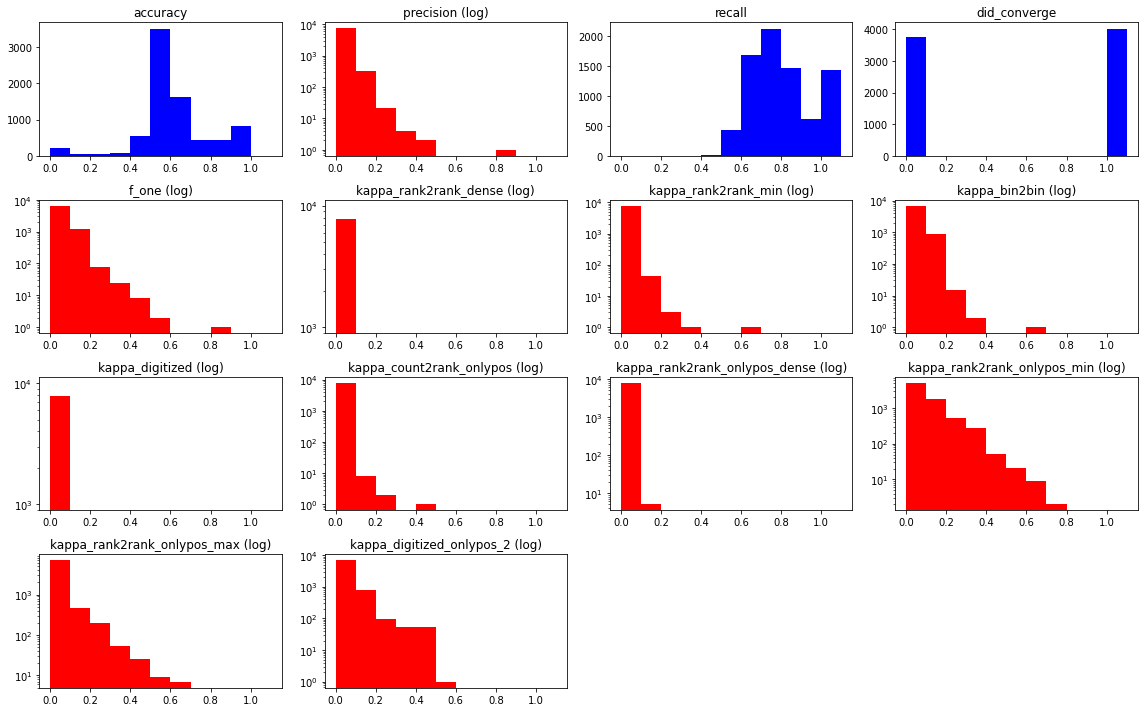

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 3, dcm_quant_measure: ppmi, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #009999">10c9cbc3b6</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

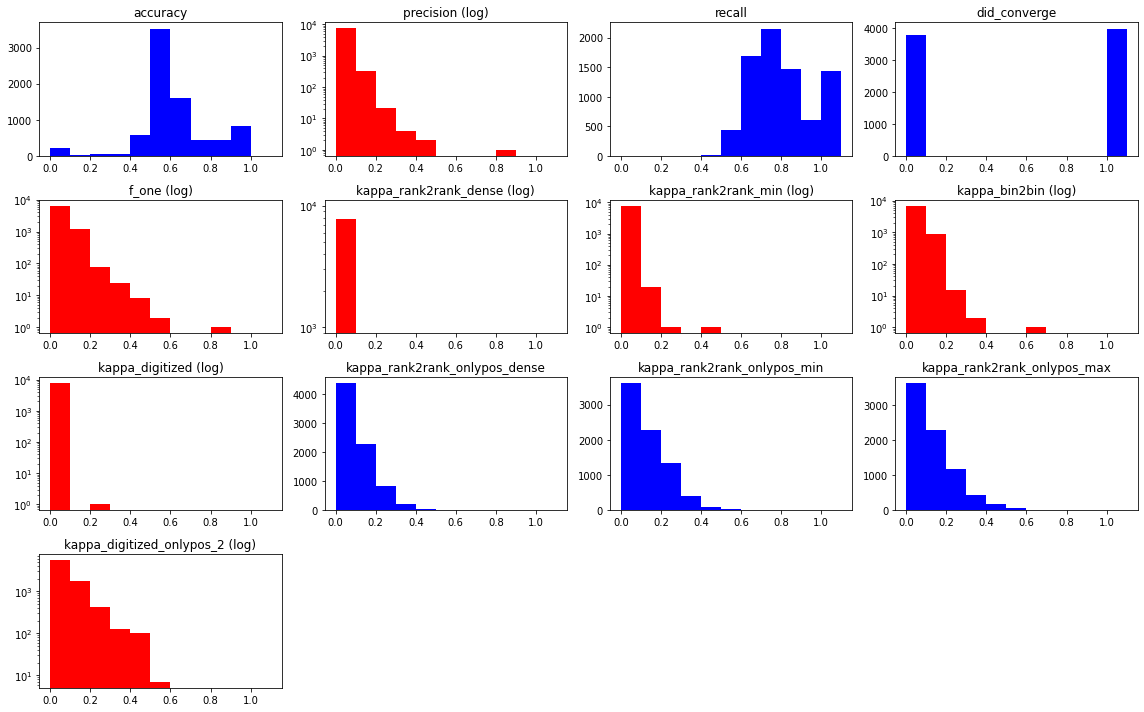

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 3, dcm_quant_measure: ppmi, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #009999">4e837e6835</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

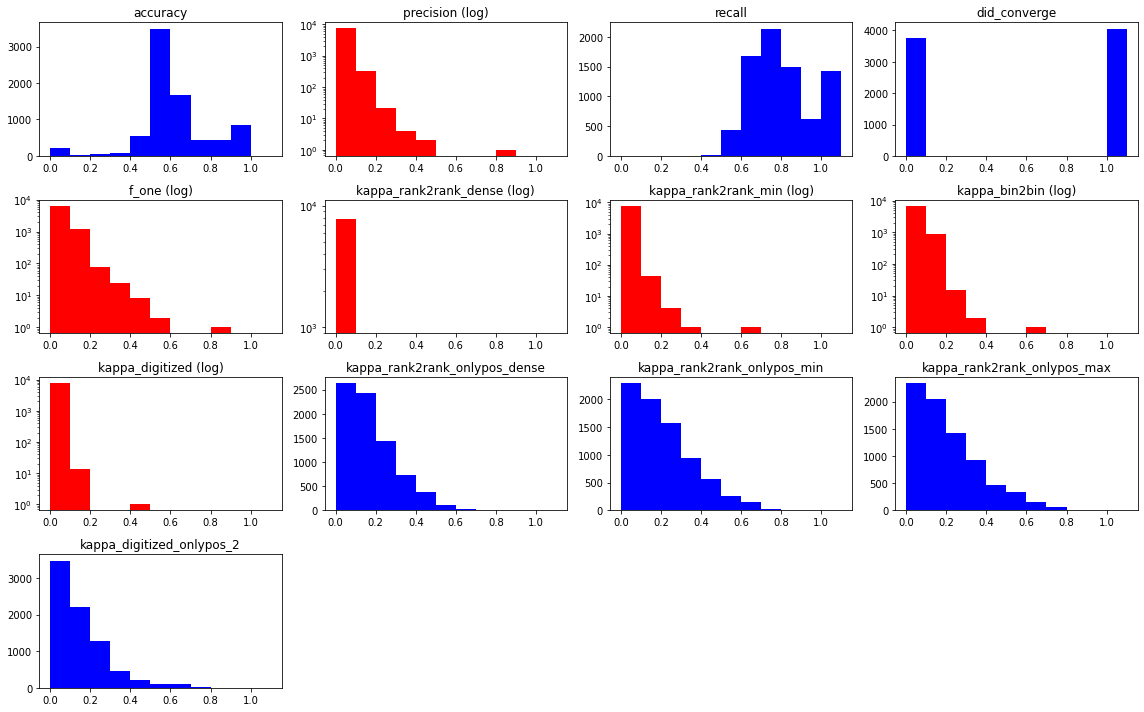

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 3, dcm_quant_measure: tfidf, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #00ff00">6a13a05cfc</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

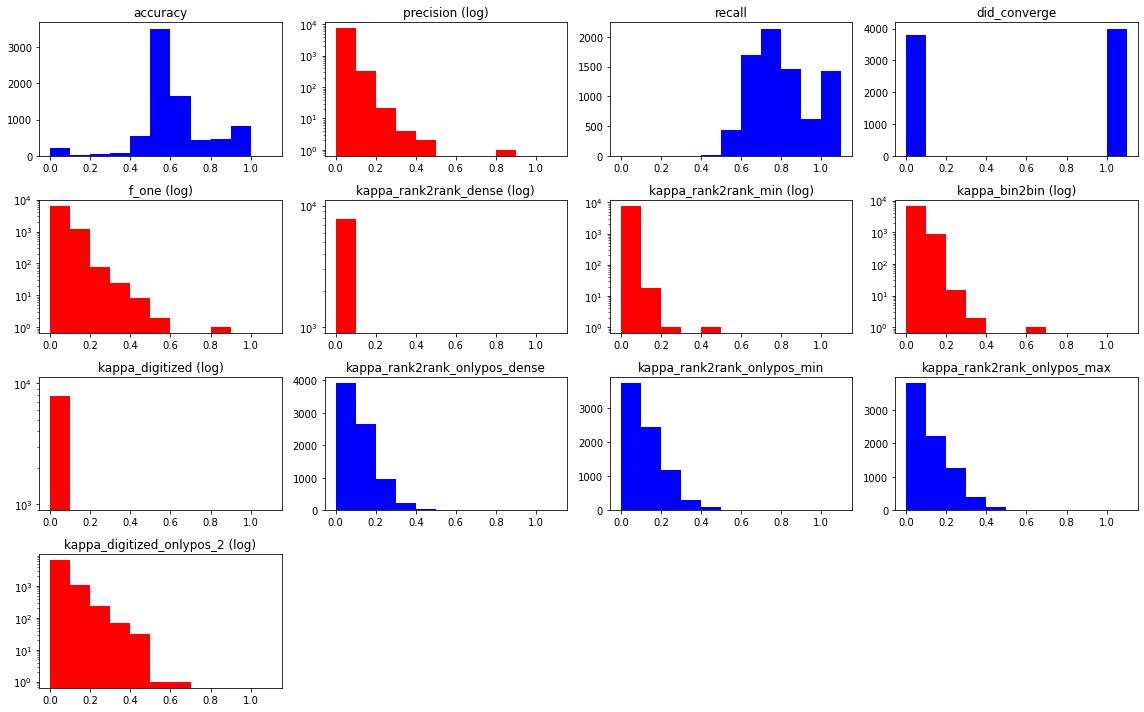

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 3, dcm_quant_measure: tfidf, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #00ff00">a32d1bfdd7</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

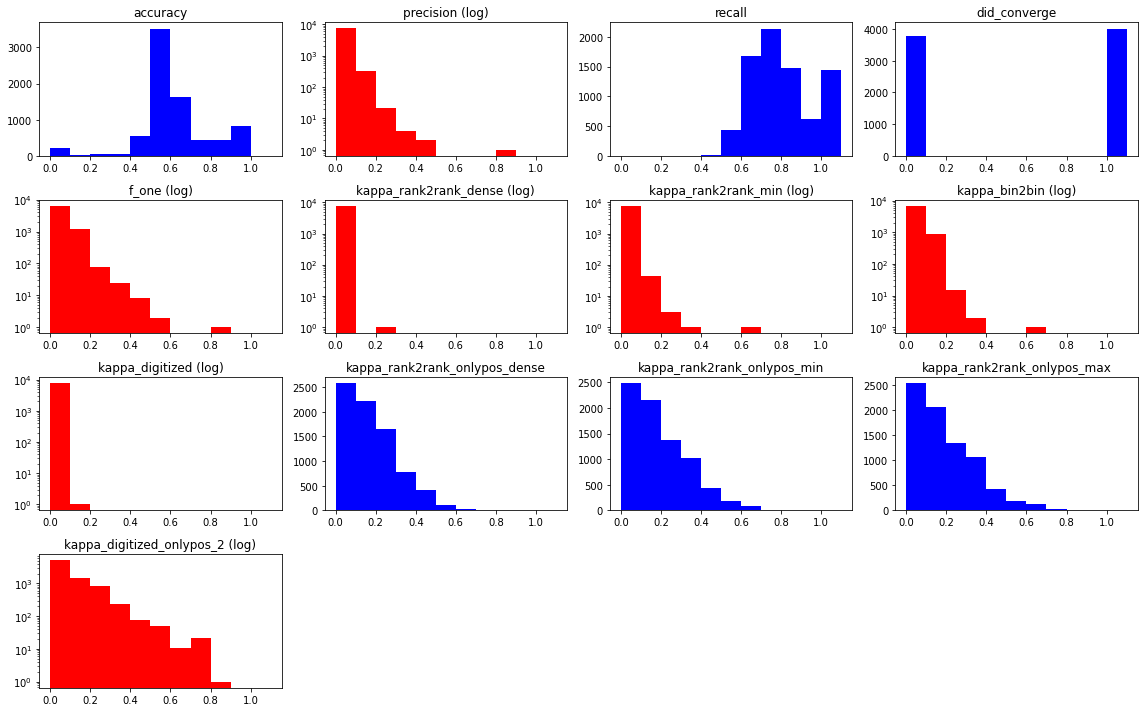

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 100, dcm_quant_measure: count, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #ff0000">e9412b3194</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

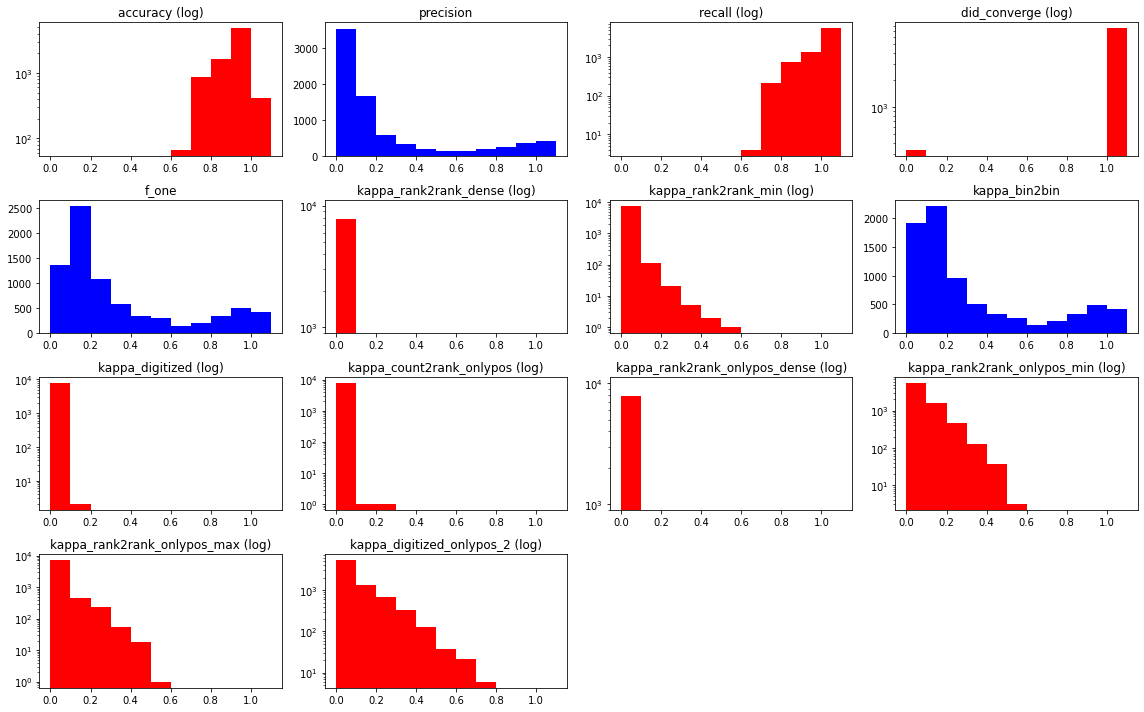

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 100, dcm_quant_measure: count, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #ff0000">20a4b95885</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

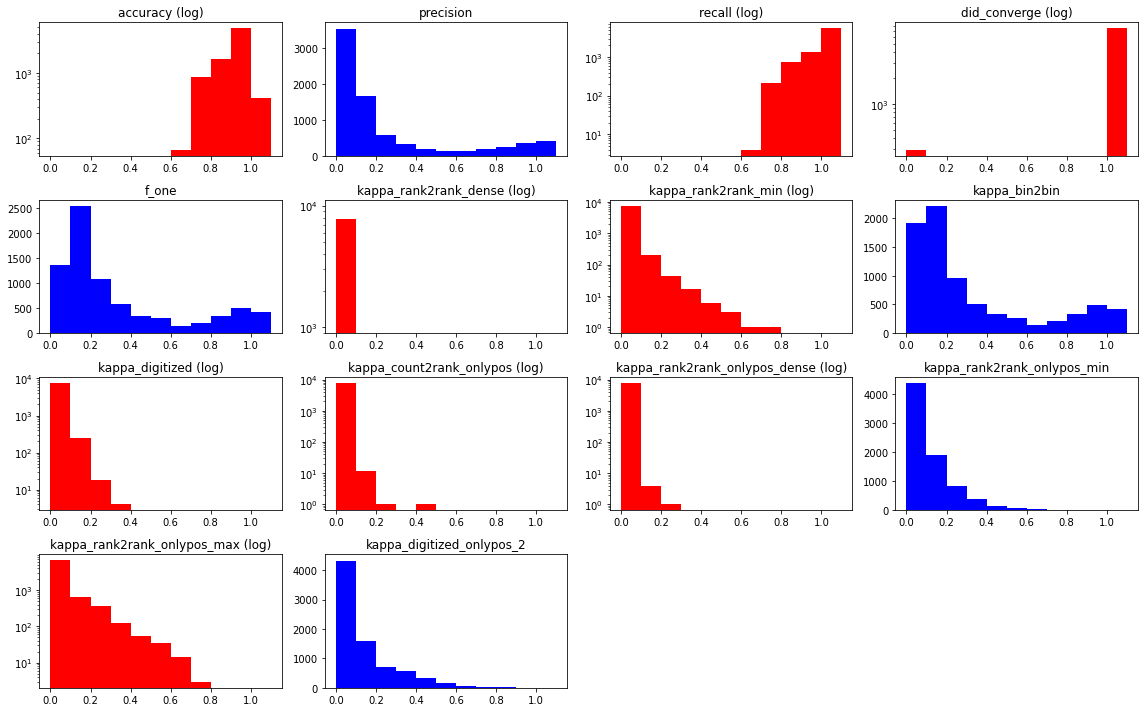

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 100, dcm_quant_measure: ppmi, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #00ff00">befd783517</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

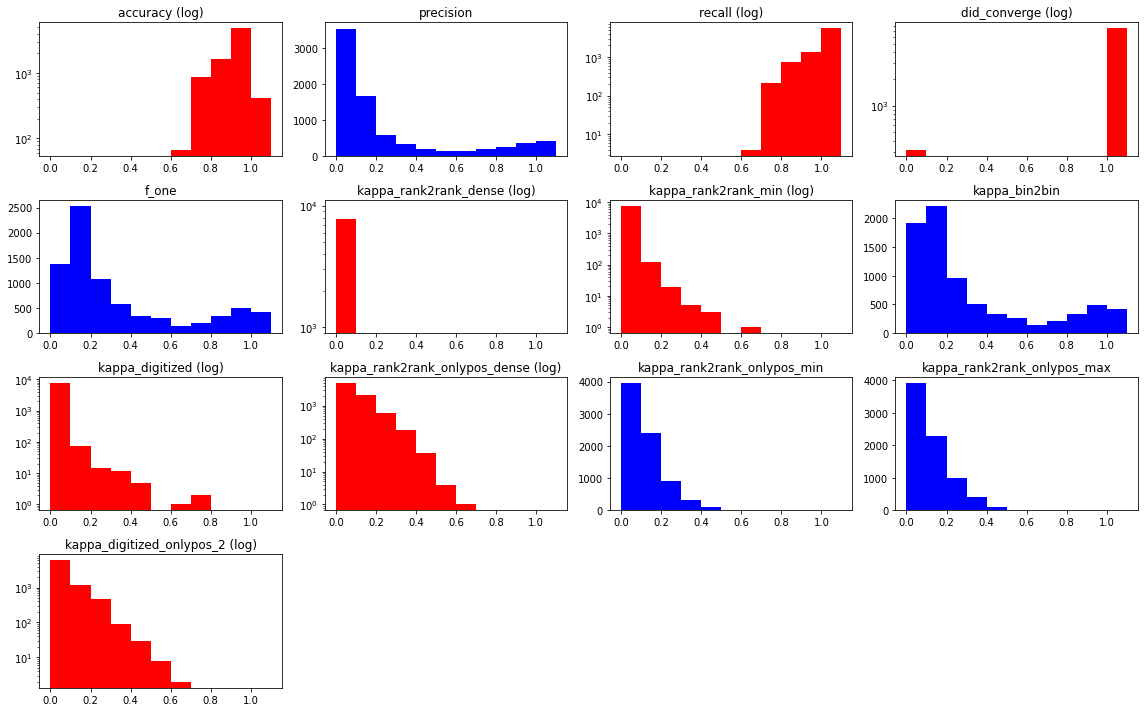

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 100, dcm_quant_measure: ppmi, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #00ffff">734b7b33f8</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

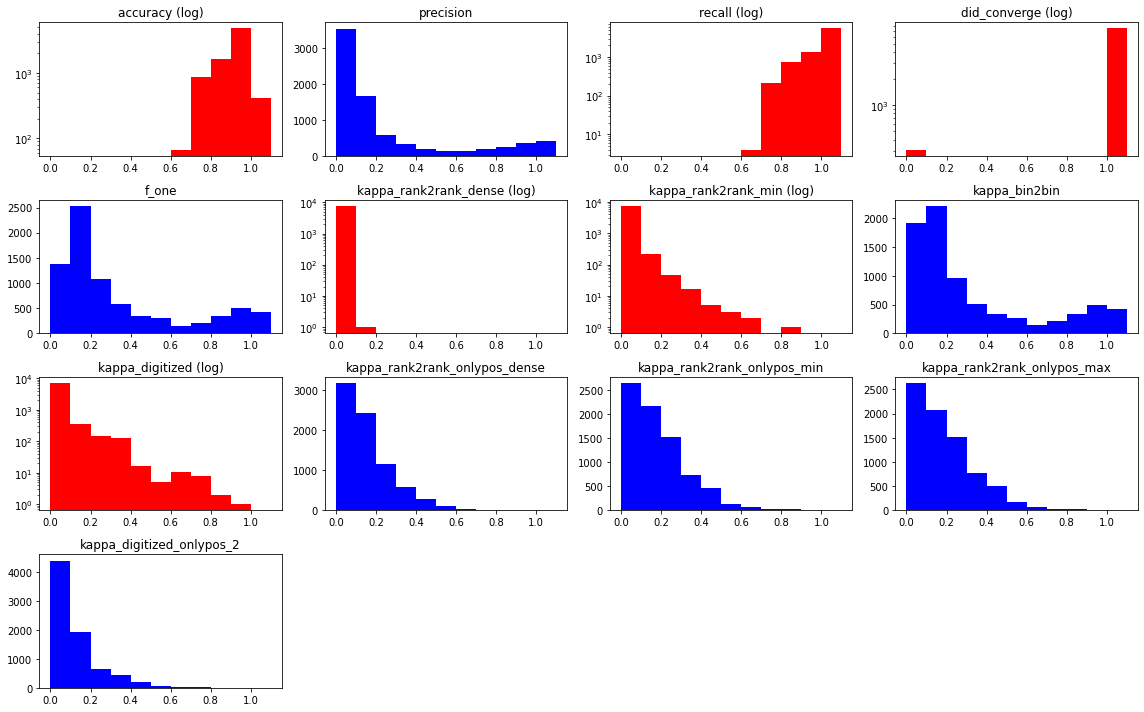

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 100, dcm_quant_measure: tfidf, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #009999">081a6b161b</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

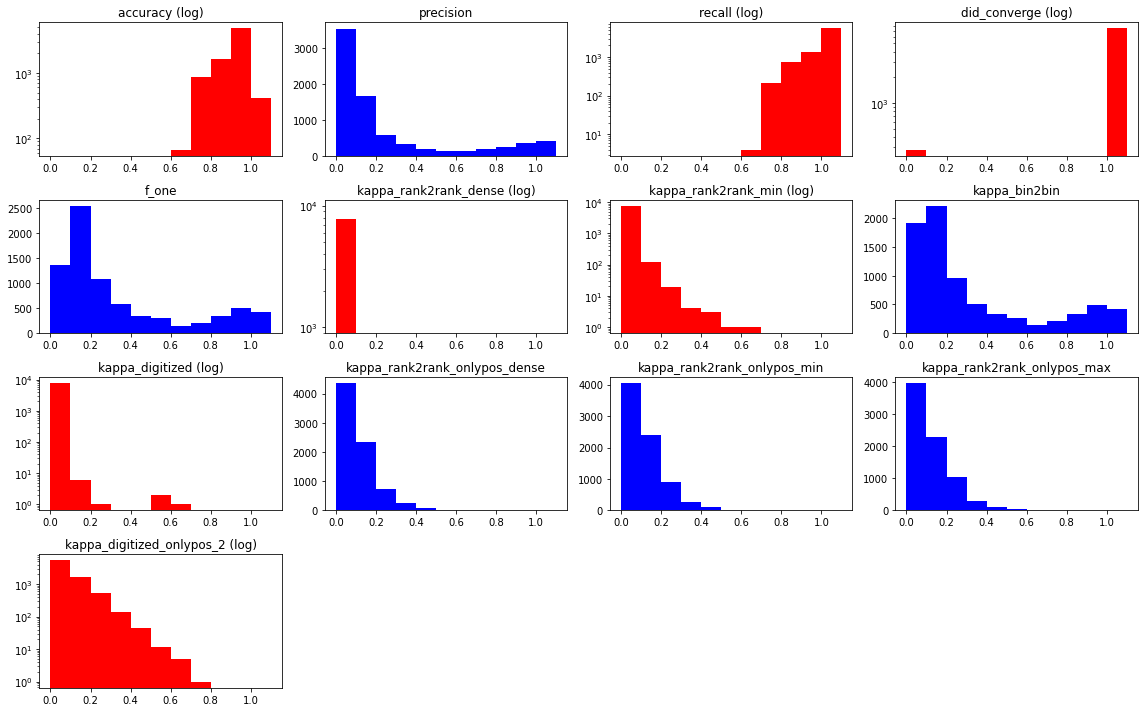

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 100, dcm_quant_measure: tfidf, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #ff00ff">d2deaad9fa</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

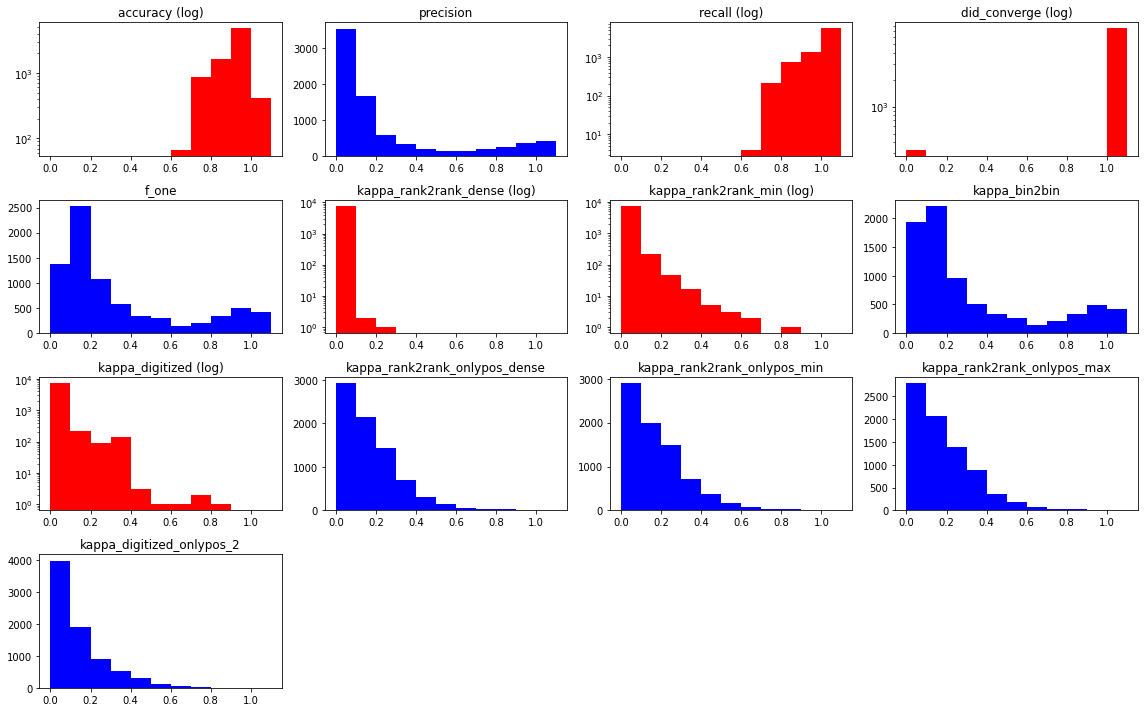

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 200, dcm_quant_measure: count, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #ff0000">5c5037e373</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

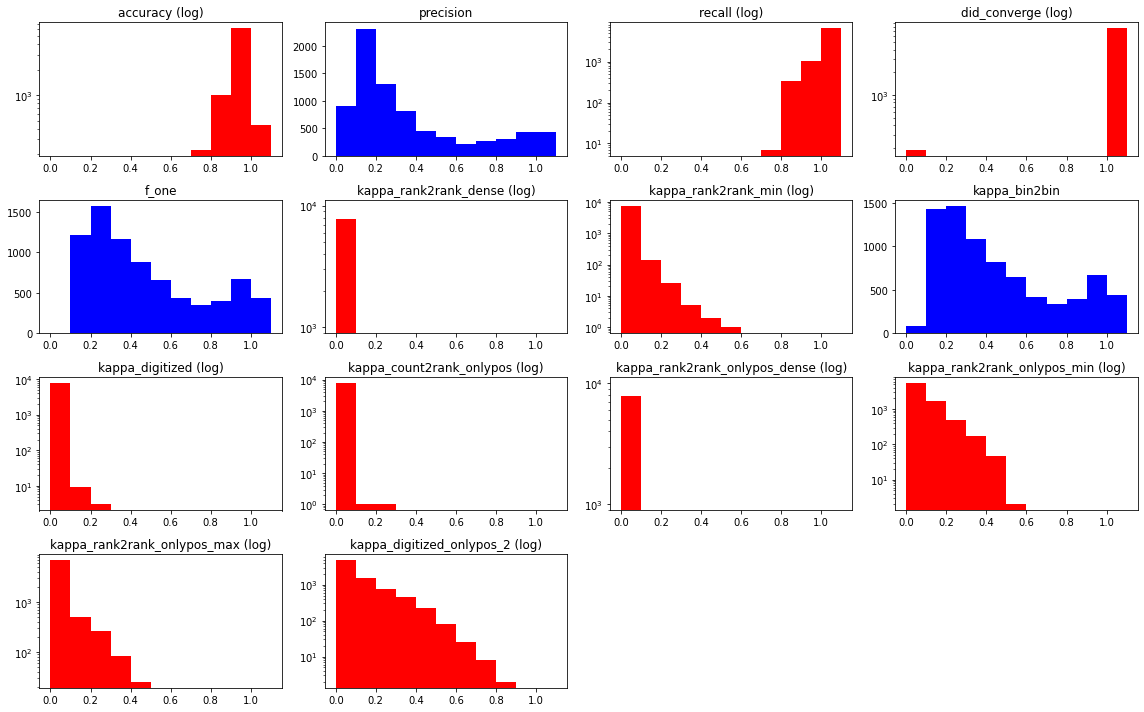

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 200, dcm_quant_measure: count, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #0000ff">abc60fcf06</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

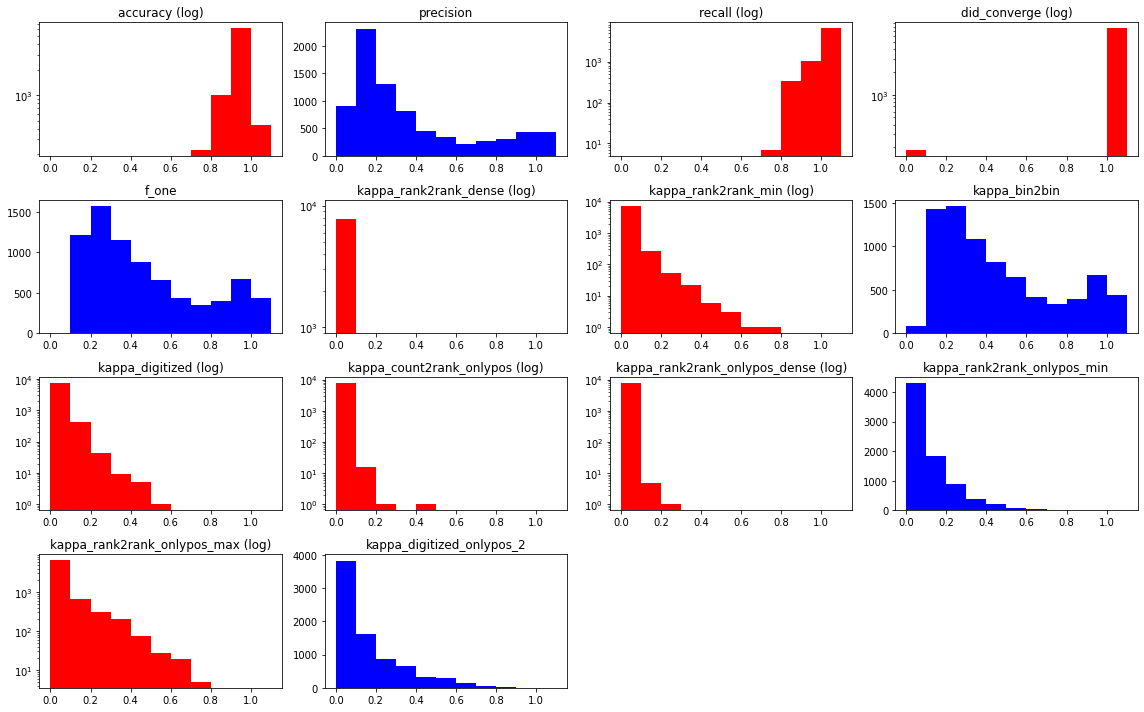

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 200, dcm_quant_measure: ppmi, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #00ff00">5c249a5de5</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

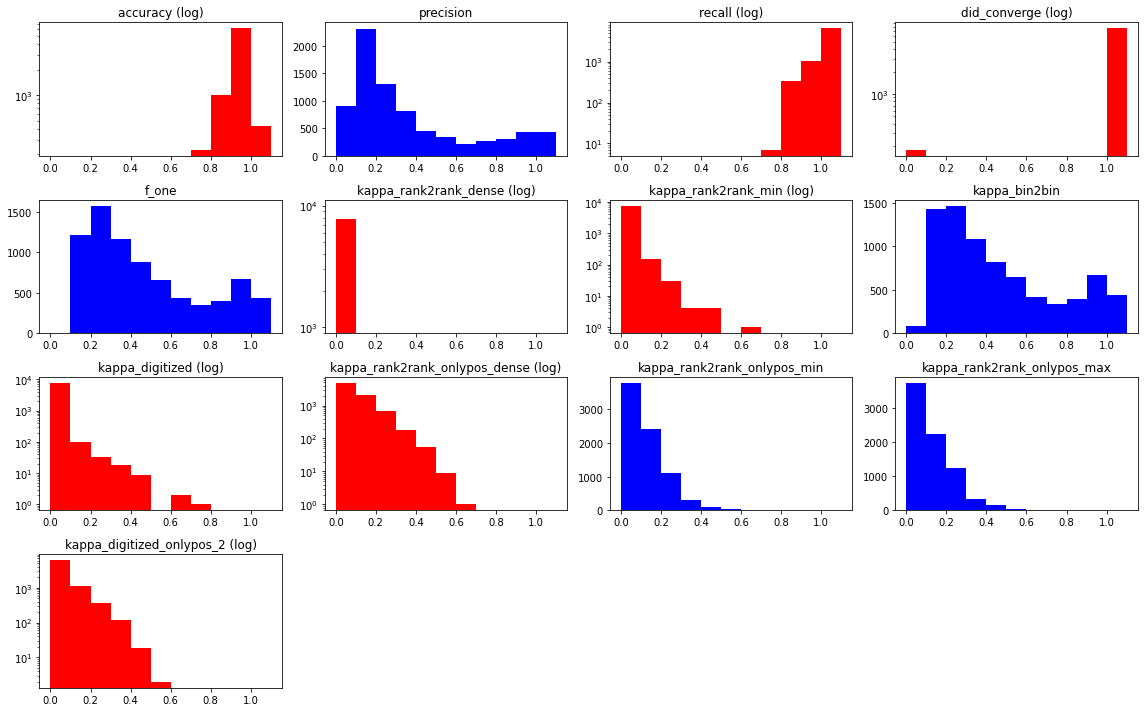

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 200, dcm_quant_measure: ppmi, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #0000ff">e26c0fce37</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

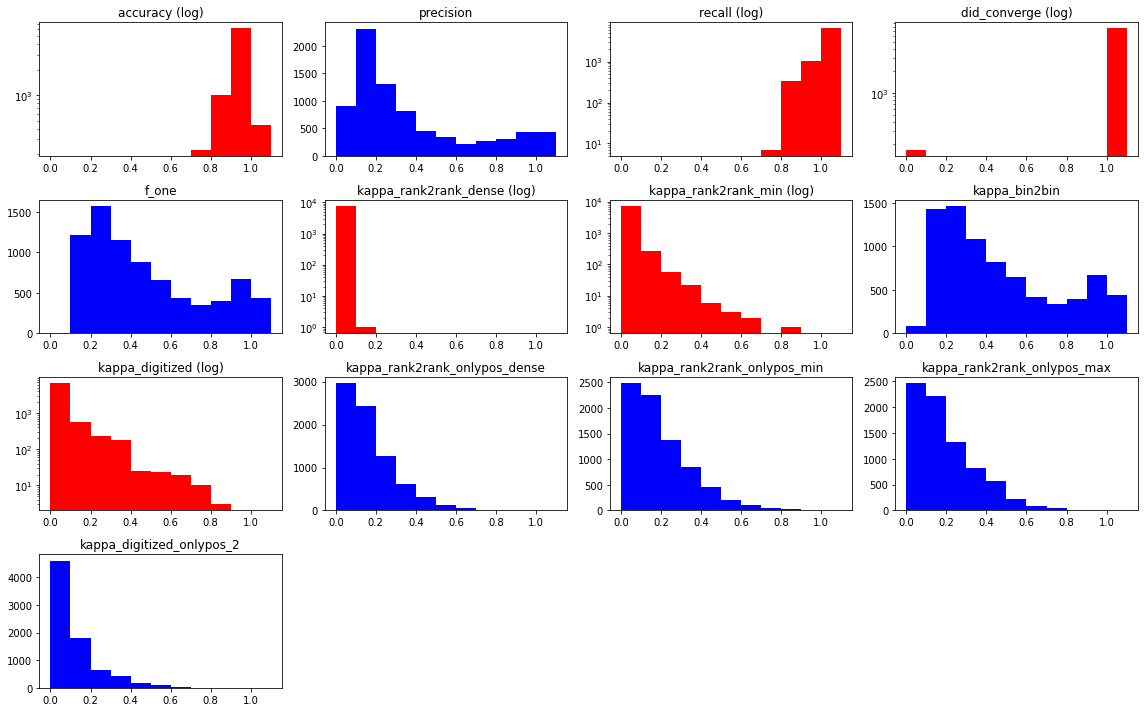

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 200, dcm_quant_measure: tfidf, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #ff0000">c2827ef6ca</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

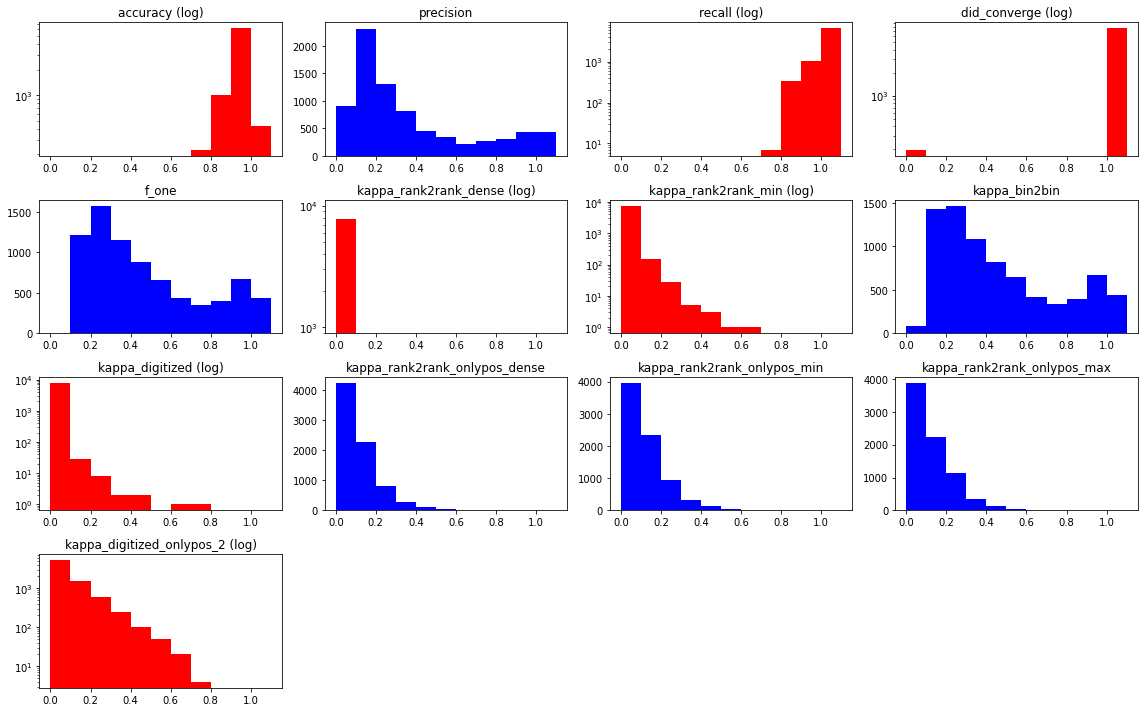

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 200, dcm_quant_measure: tfidf, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #ff00ff">f34bf093f4</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

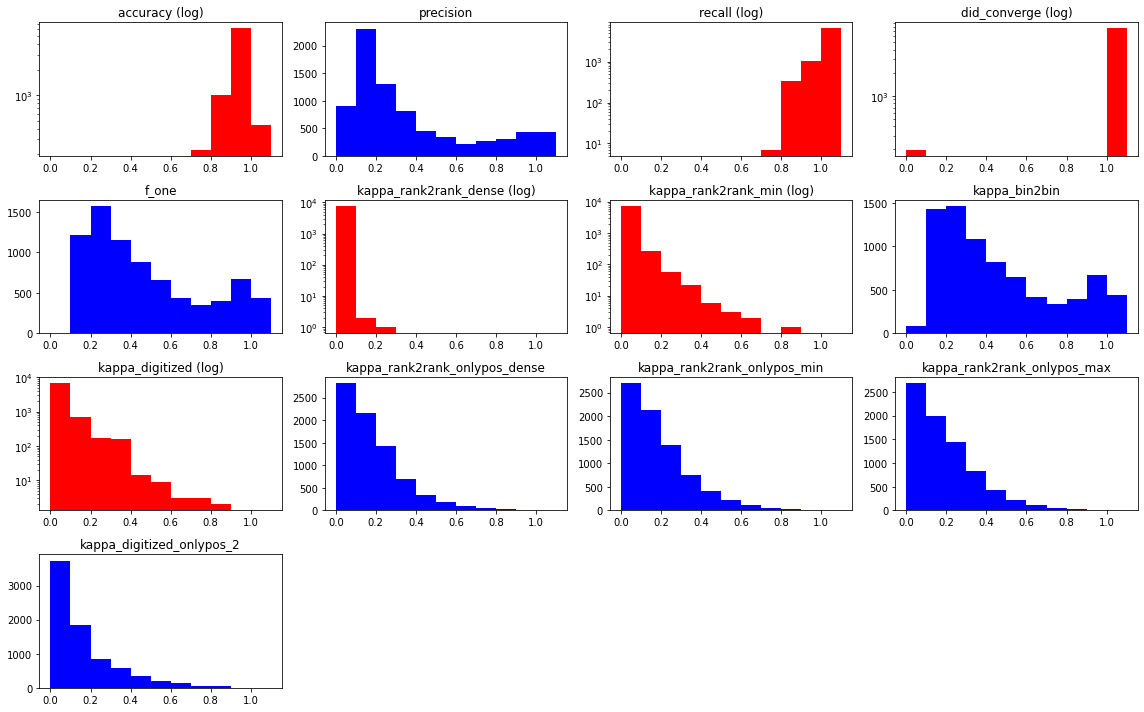

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 3, dcm_quant_measure: count, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #ff0000">010a587de2</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

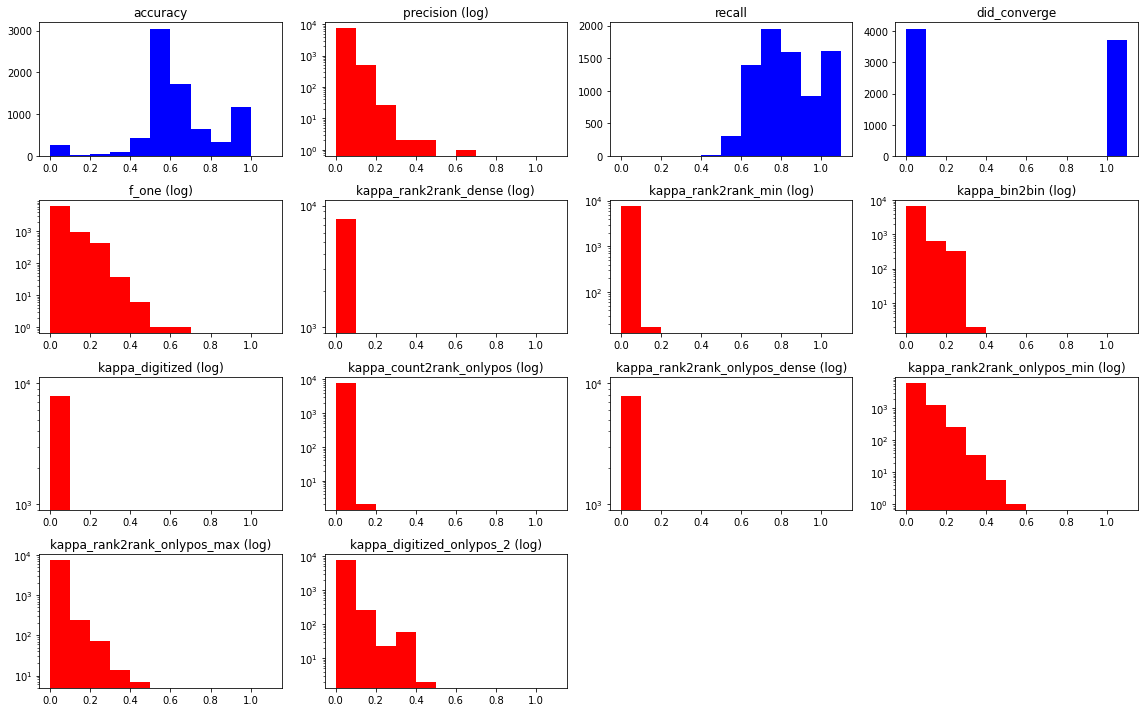

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 3, dcm_quant_measure: count, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #ff00ff">abac40987b</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

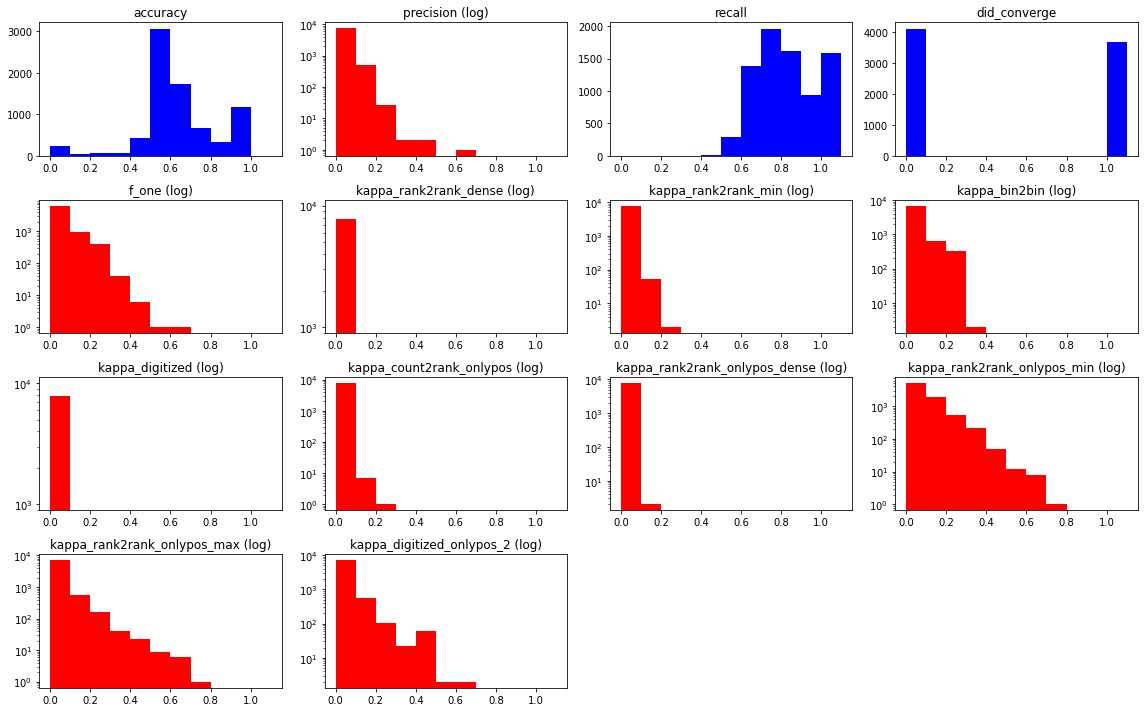

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 3, dcm_quant_measure: ppmi, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #009999">9de56be73a</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

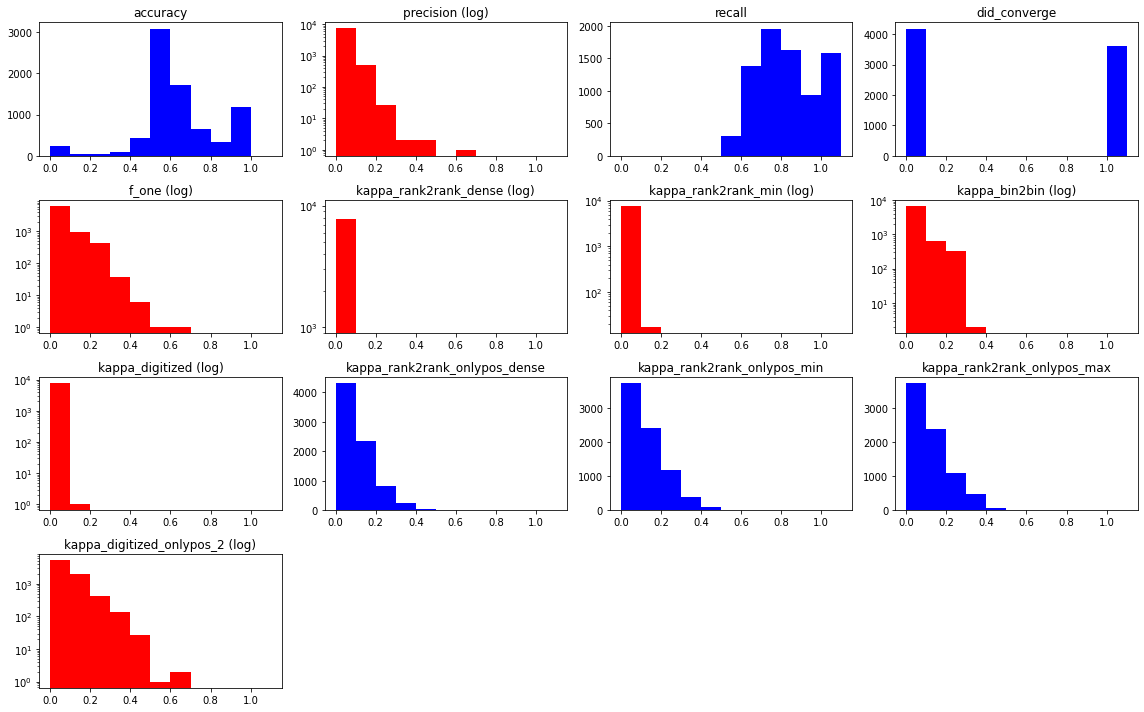

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 3, dcm_quant_measure: ppmi, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #009999">2f9a77dd40</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

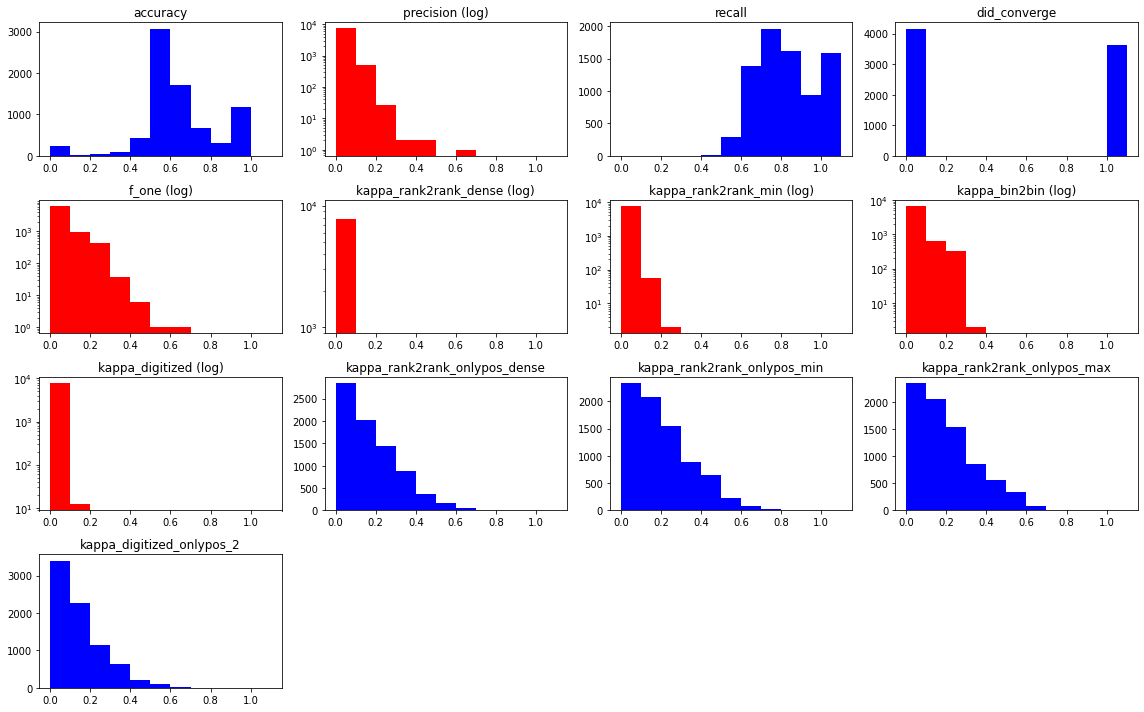

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 3, dcm_quant_measure: tfidf, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #00ff00">e38795e8e3</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

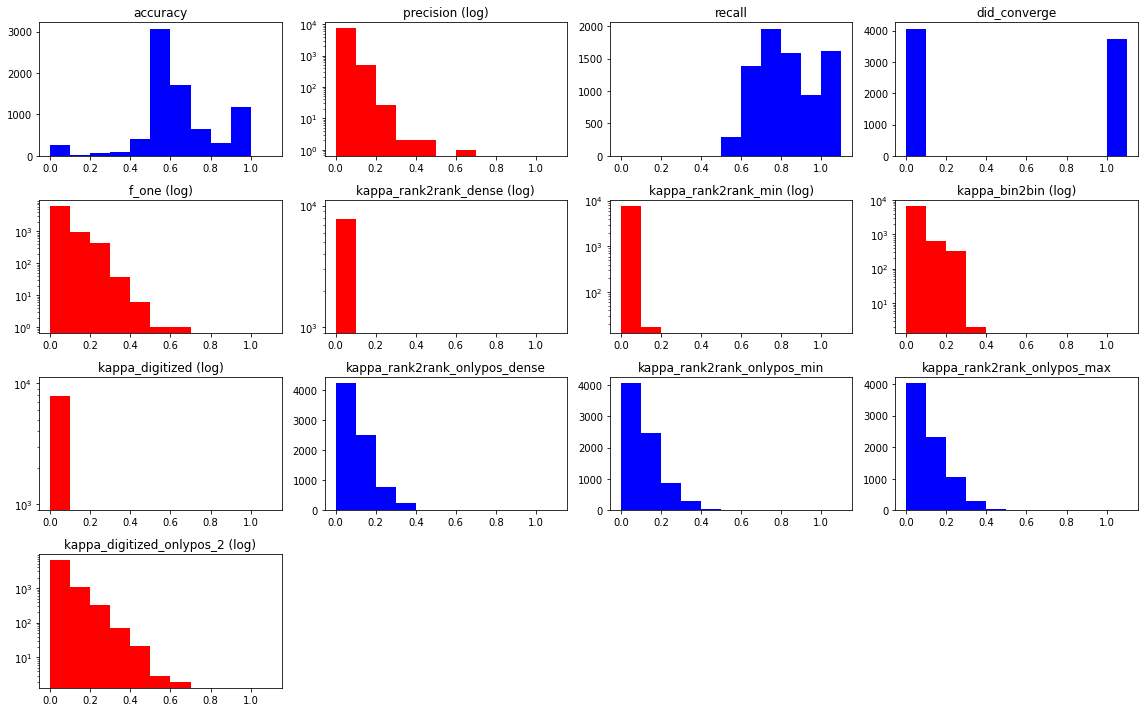

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 3, dcm_quant_measure: tfidf, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #0000ff">583614cd35</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

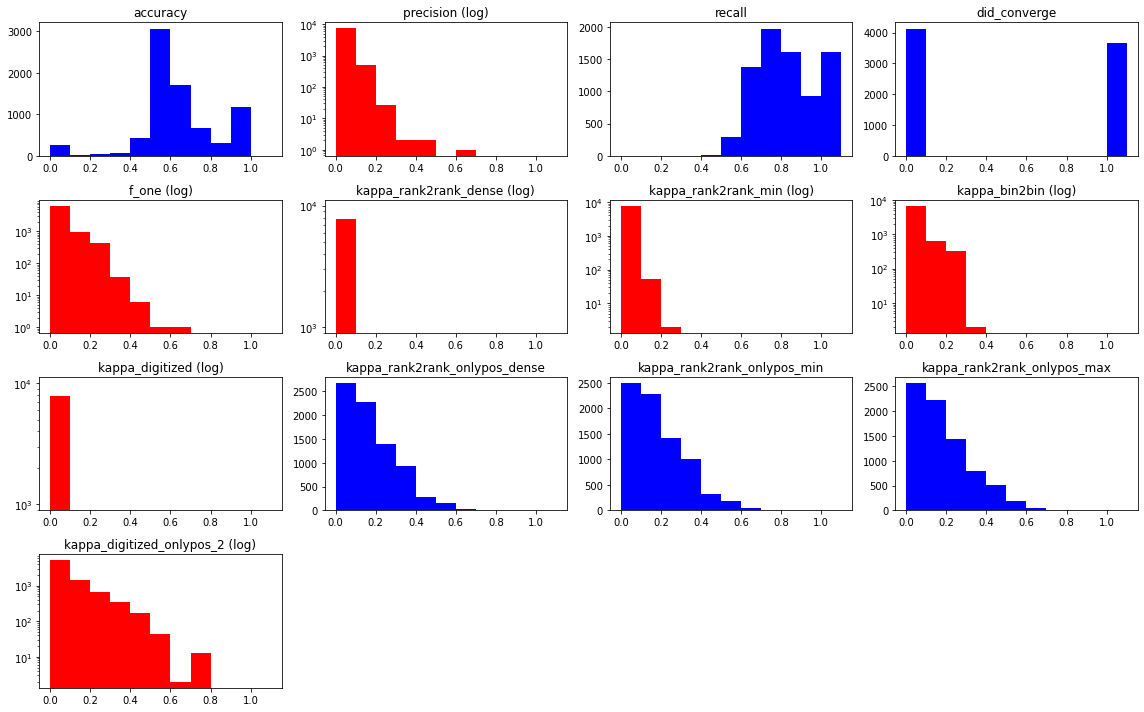

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 100, dcm_quant_measure: count, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #0000ff">b95f09fa21</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

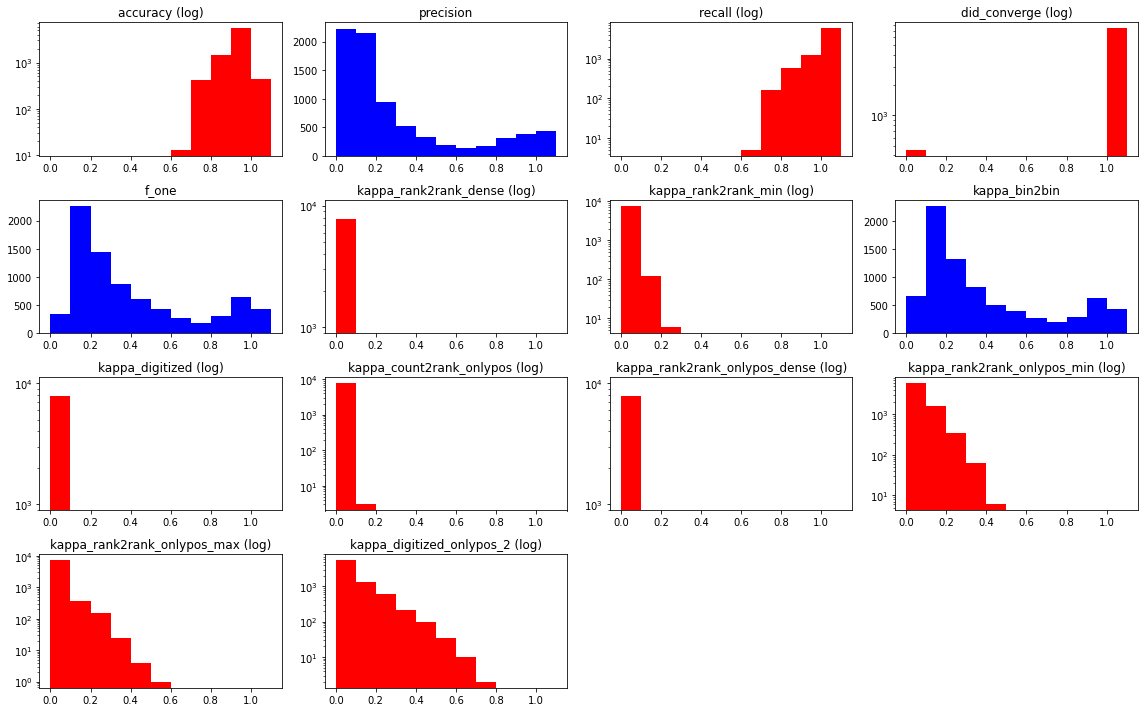

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 100, dcm_quant_measure: count, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #ff0000">b8a466a08a</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

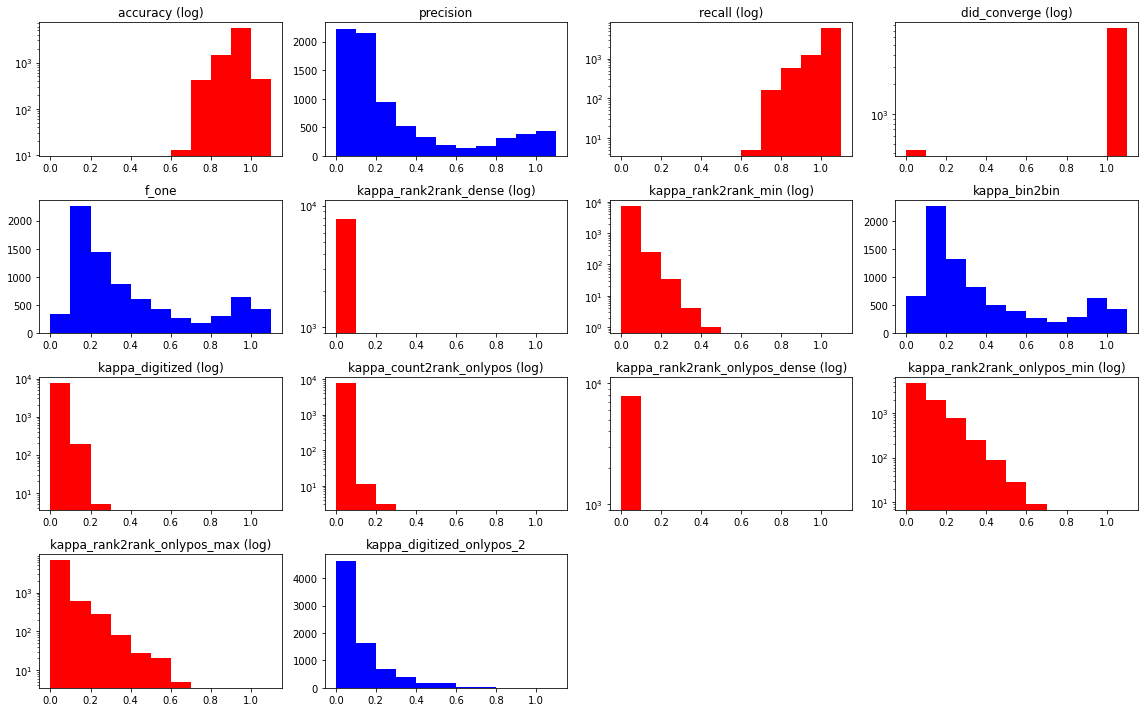

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 100, dcm_quant_measure: ppmi, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #0000ff">47bcde6ede</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

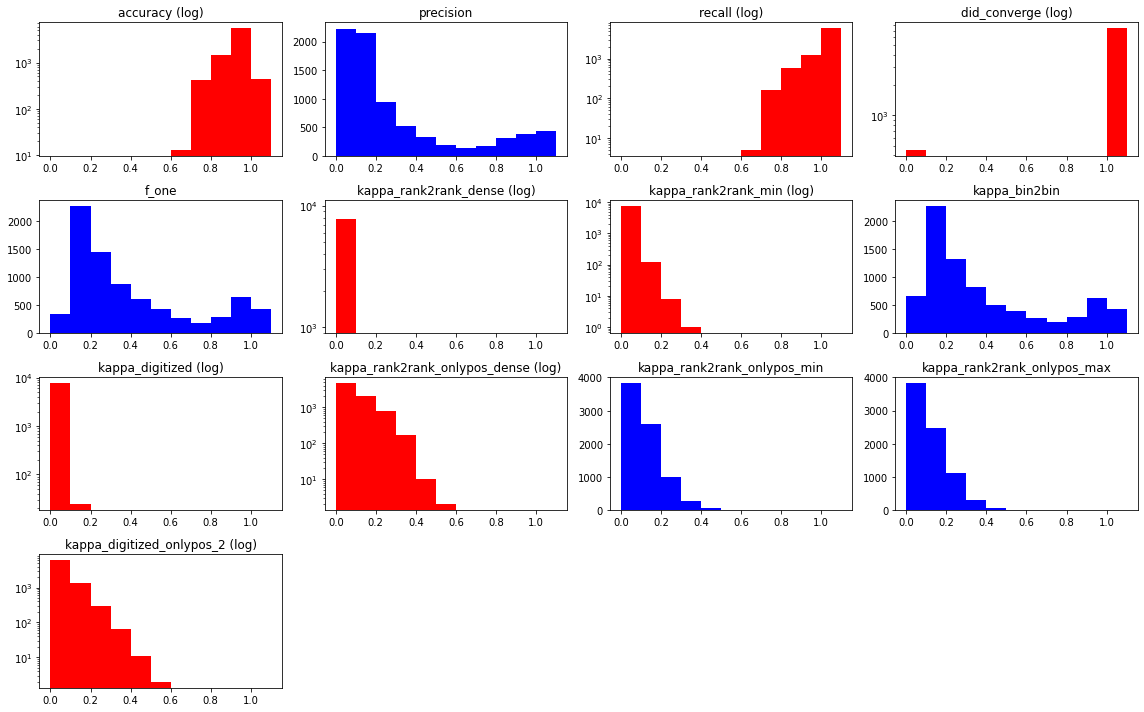

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 100, dcm_quant_measure: ppmi, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #00ffff">8acd7be7d8</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

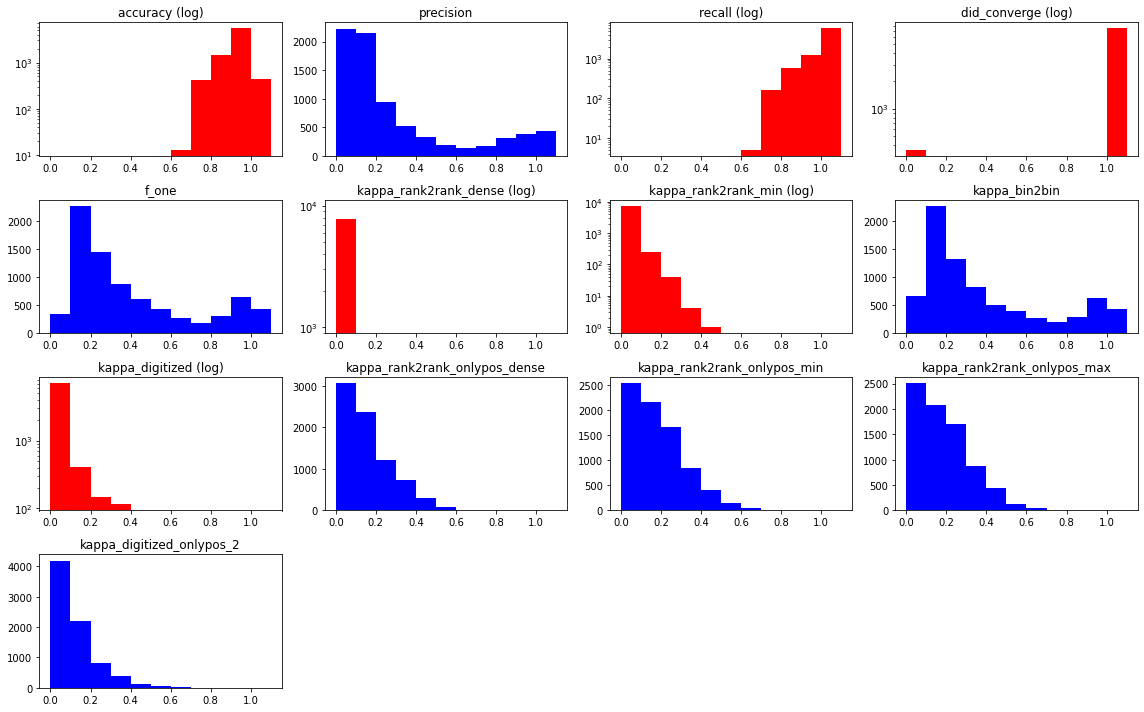

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 100, dcm_quant_measure: tfidf, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #00ffff">945f1ecdc6</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

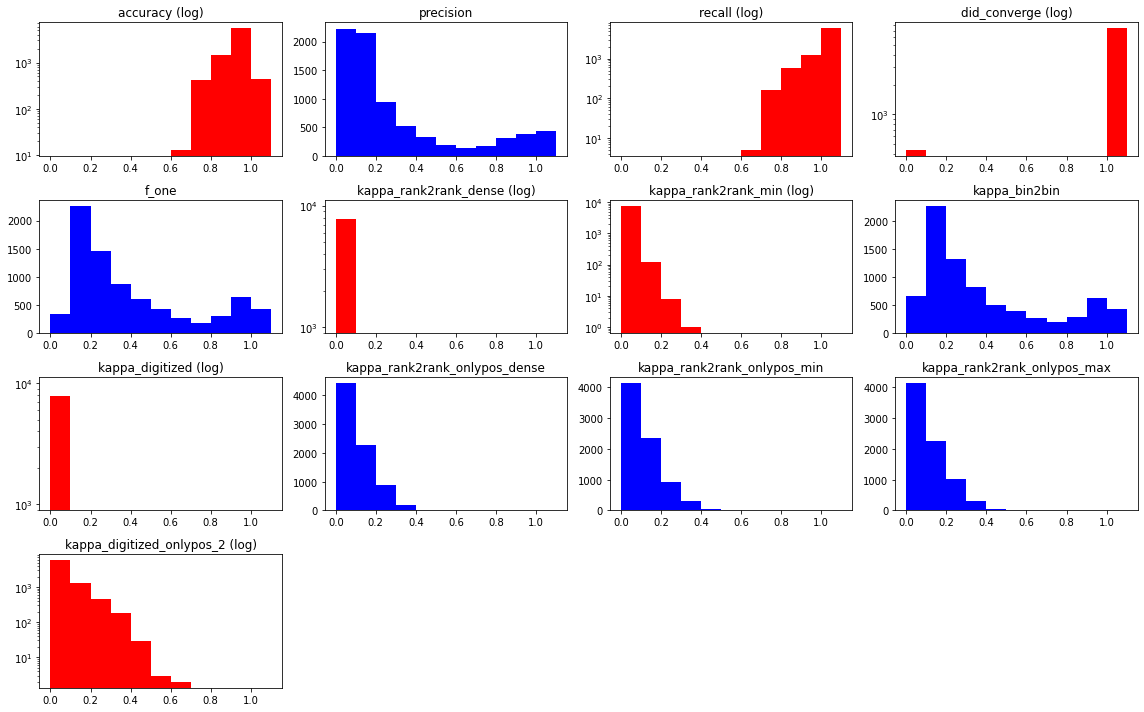

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 100, dcm_quant_measure: tfidf, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #009999">5adca7ff46</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

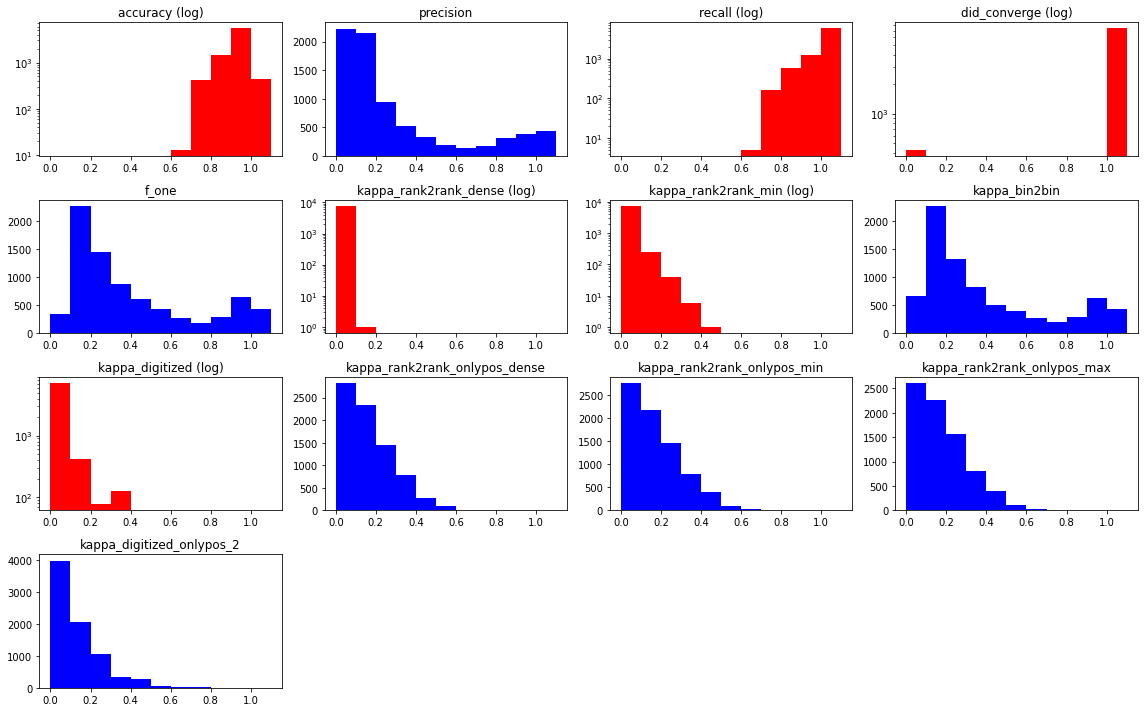

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 200, dcm_quant_measure: count, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #ffff00">edf44f37b2</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

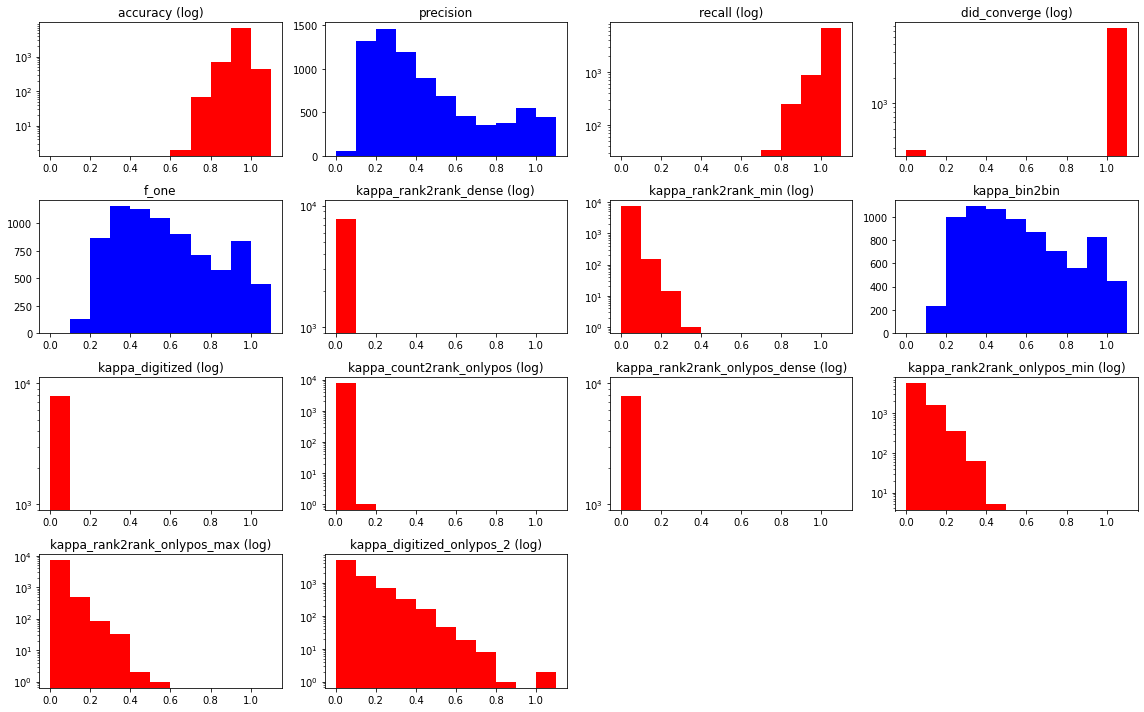

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 200, dcm_quant_measure: count, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #0000ff">3a56e3a1f6</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

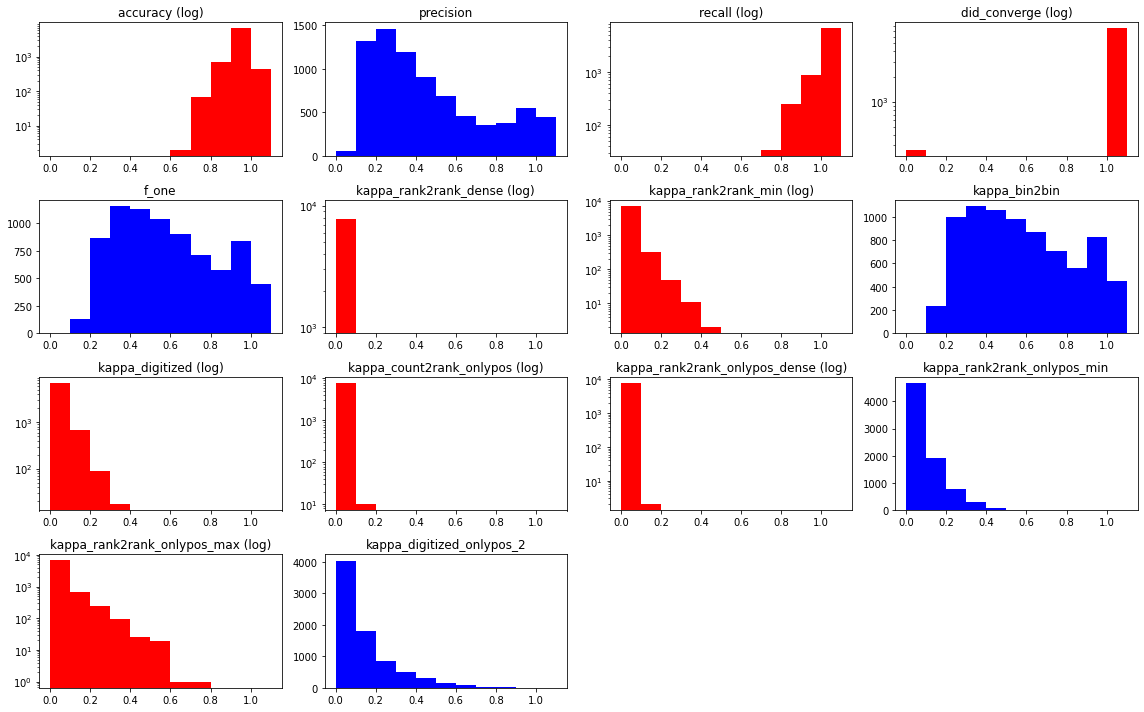

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 200, dcm_quant_measure: ppmi, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #0000ff">8a69270b47</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

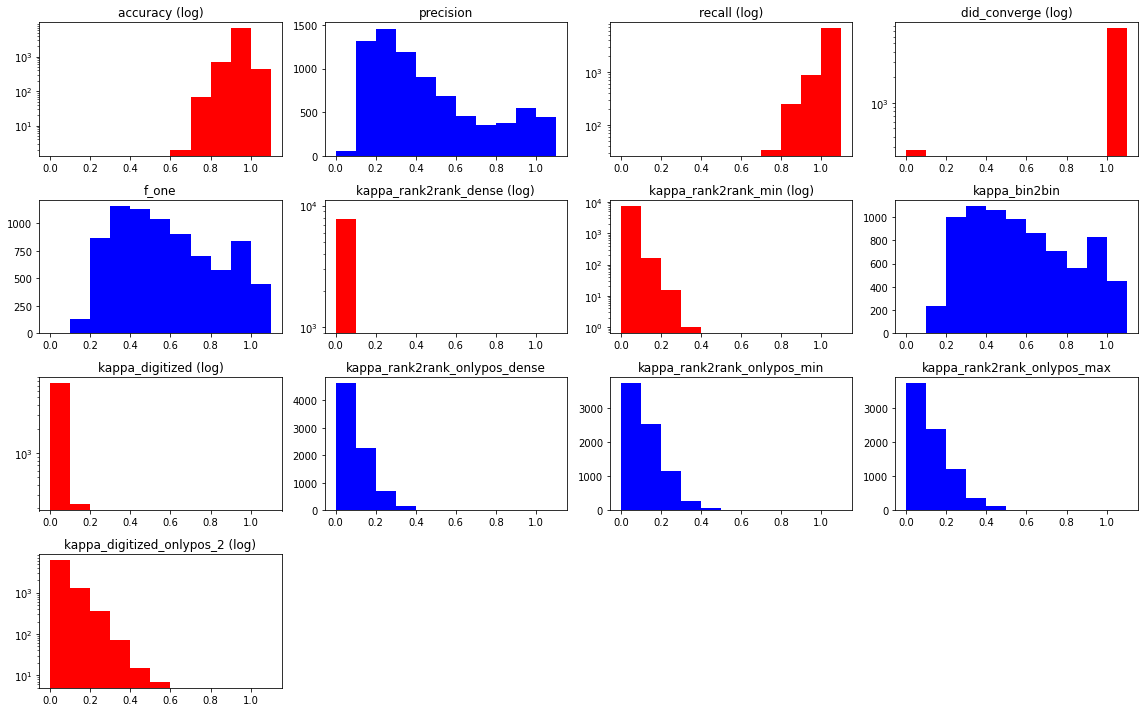

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 200, dcm_quant_measure: ppmi, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #009999">852048716d</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

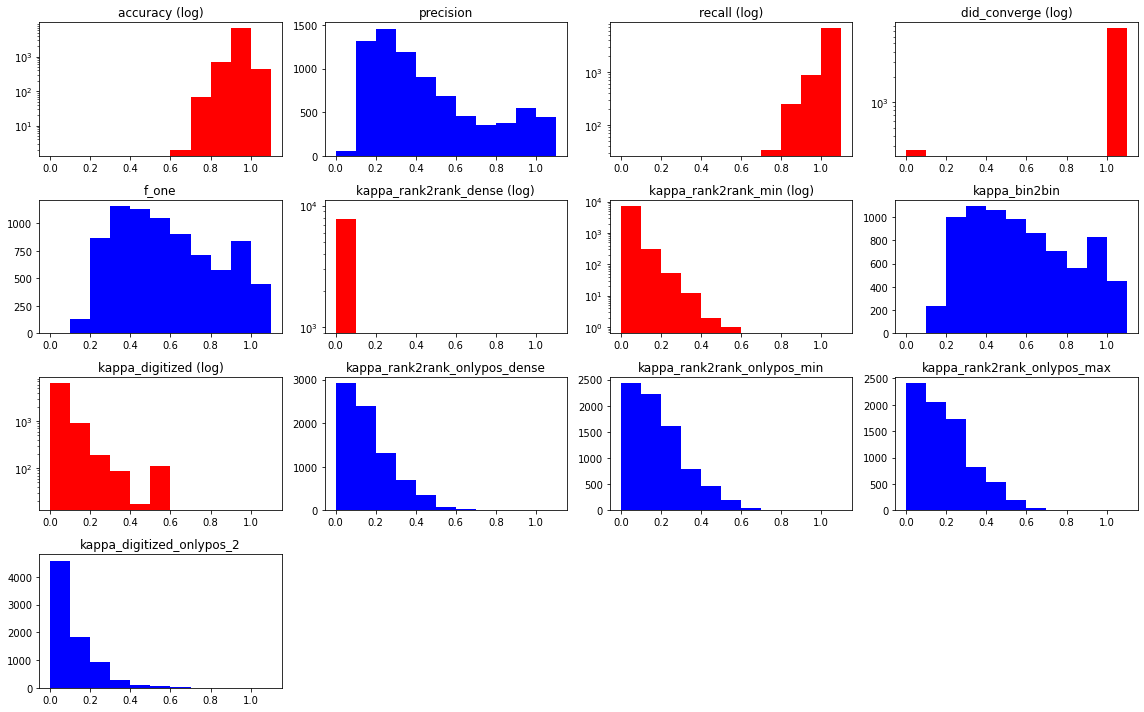

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 200, dcm_quant_measure: tfidf, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #00ffff">ca6b53b071</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

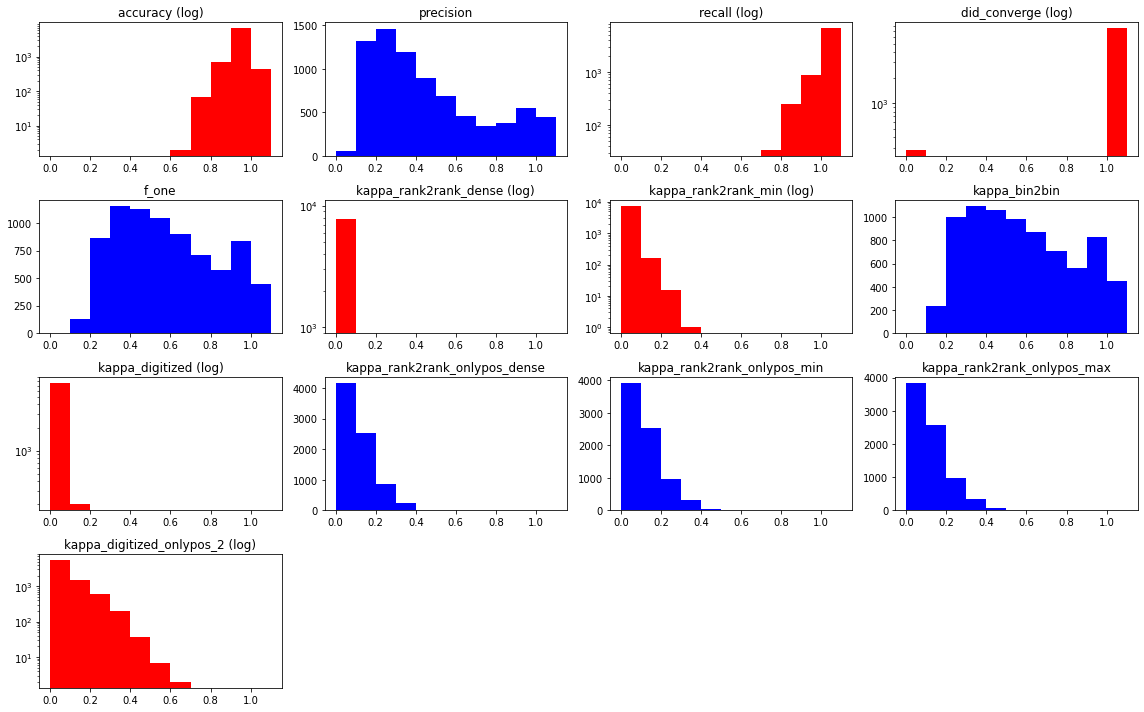

## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 200, dcm_quant_measure: tfidf, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #00ffff">ee91f169a5</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">ppmi</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

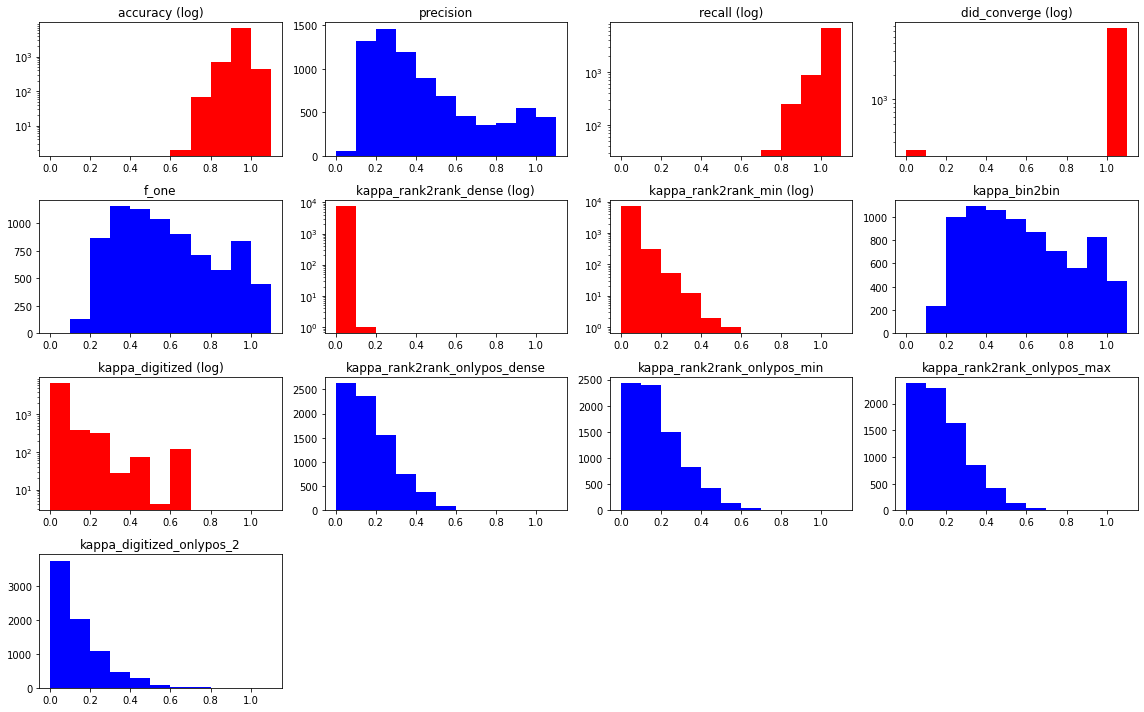

## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 3, dcm_quant_measure: count, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #00ff00">ecb67a09d7</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

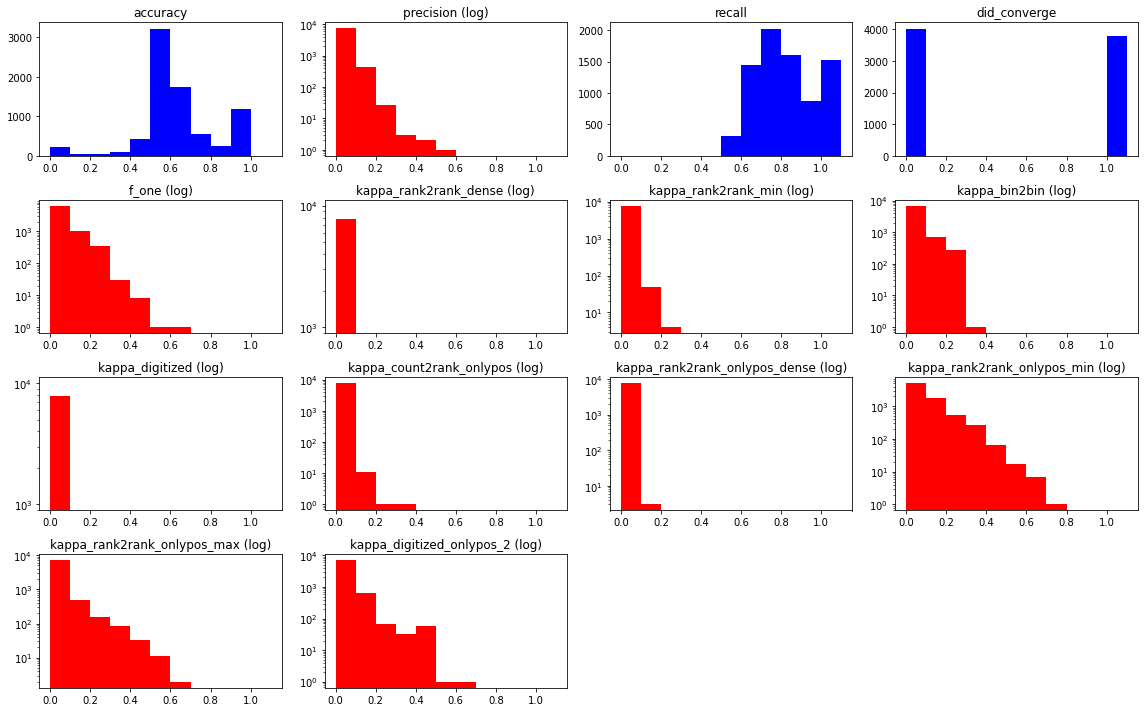

## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 3, dcm_quant_measure: ppmi, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #009999">fe10f6a414</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

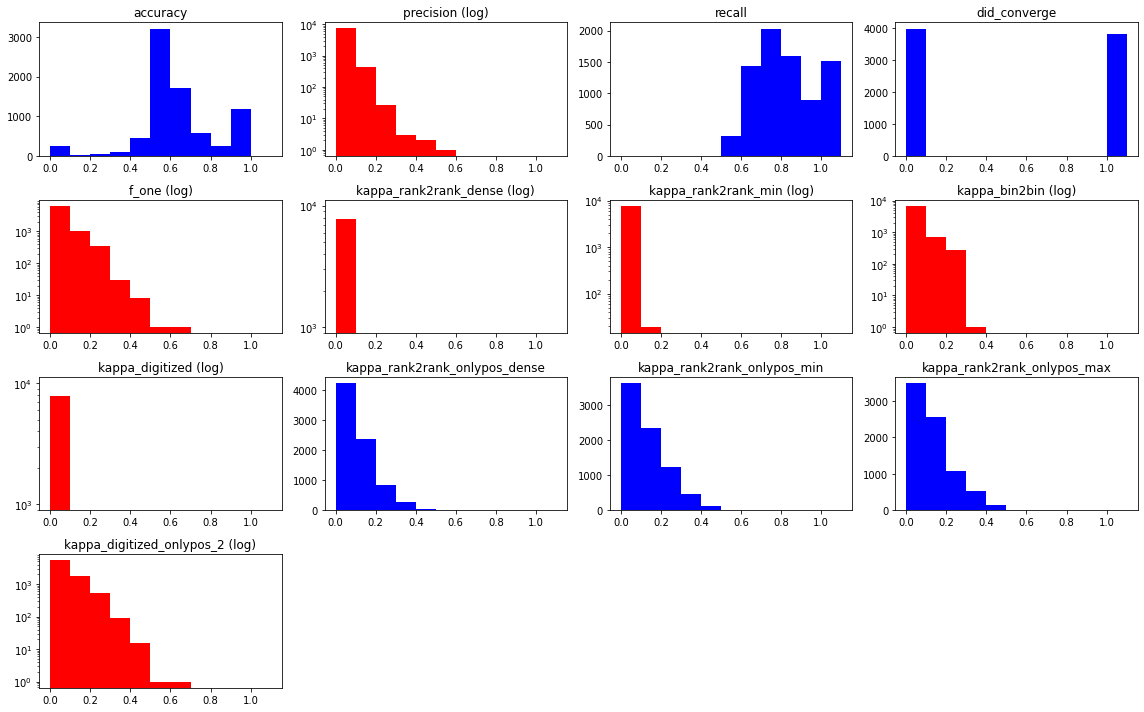

## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 3, dcm_quant_measure: ppmi, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #0000ff">54124c564d</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

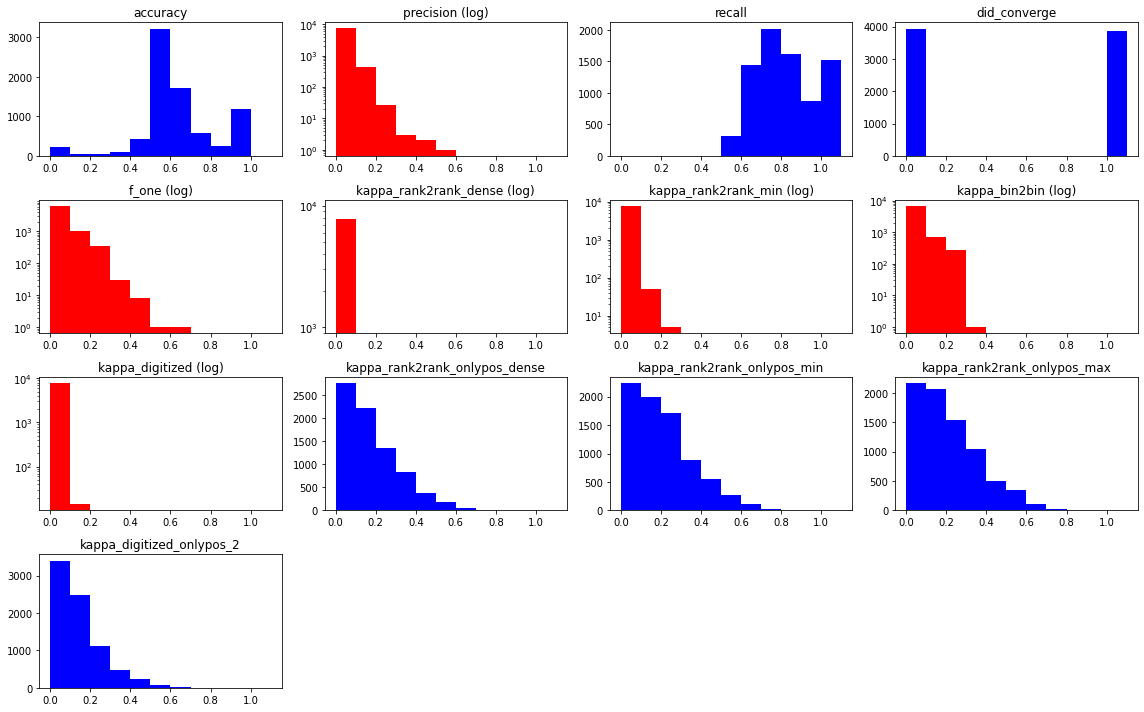

## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 3, dcm_quant_measure: tfidf, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #00ff00">c70435549b</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

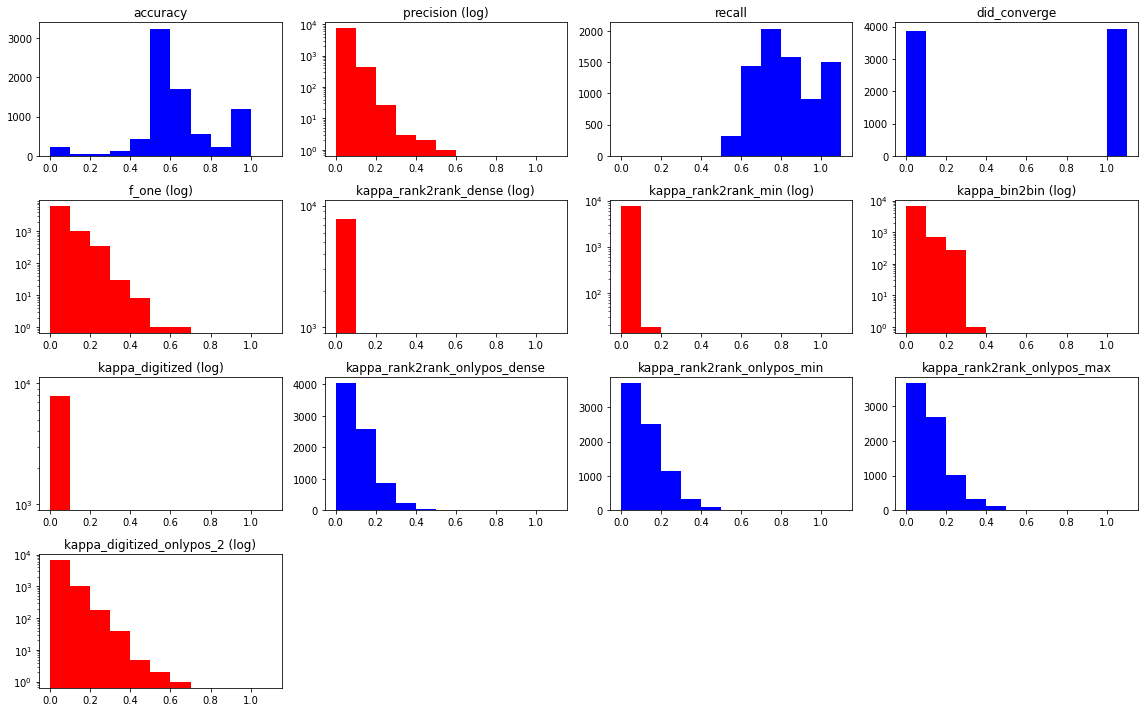

## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 3, dcm_quant_measure: tfidf, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #009999">367ef9878d</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">3</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

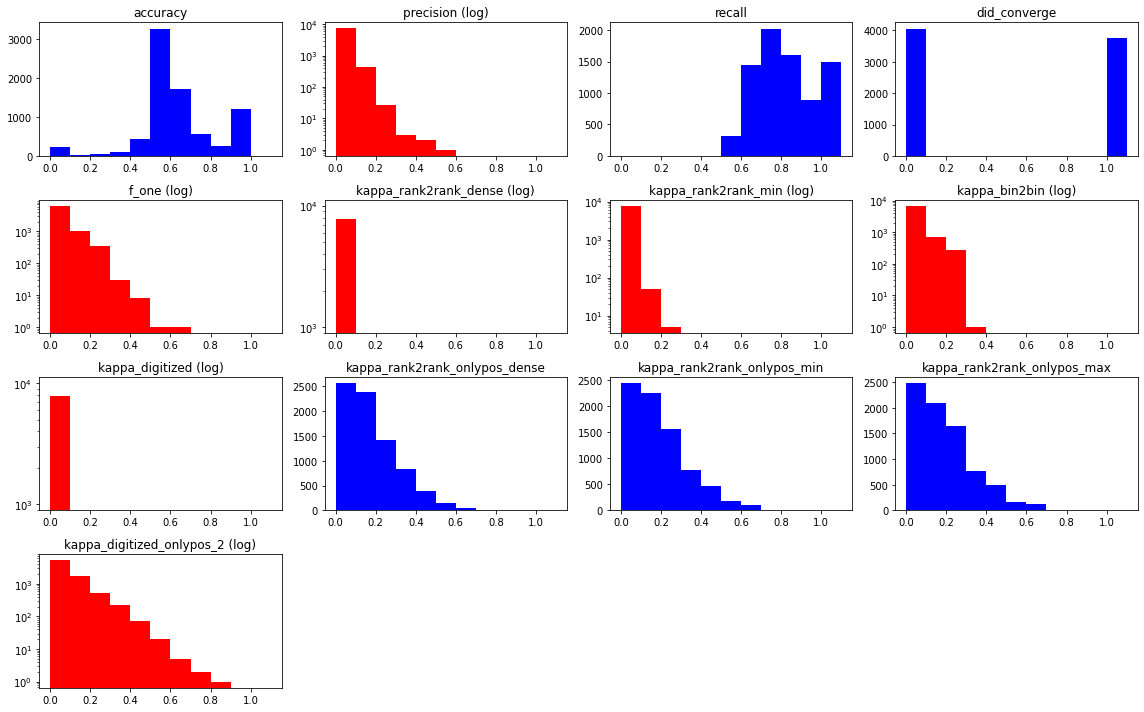

## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 100, dcm_quant_measure: count, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #00ff00">b36771d0c0</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

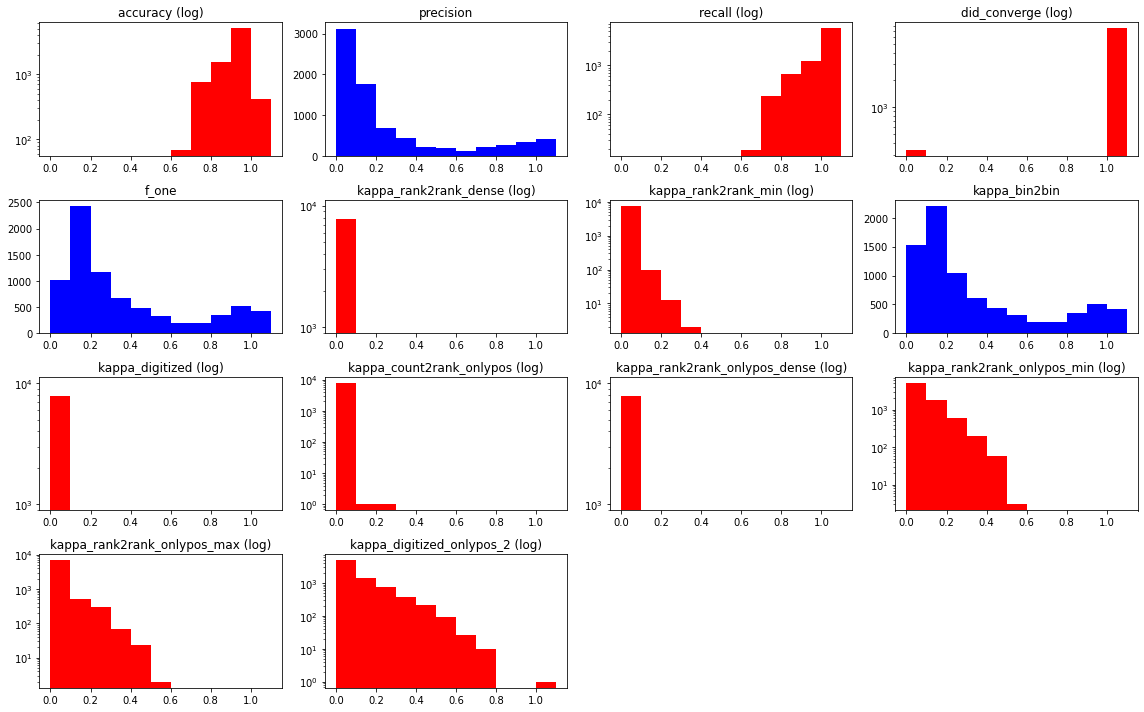

## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 100, dcm_quant_measure: count, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #00ffff">561a6f7c91</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

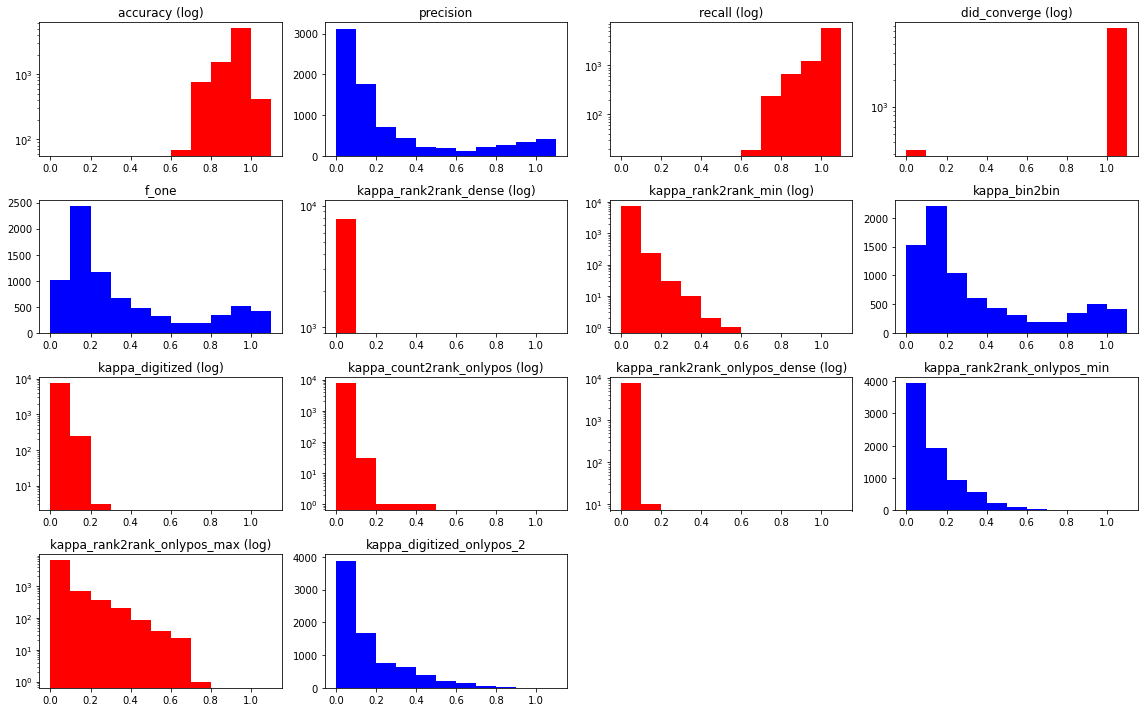

## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 100, dcm_quant_measure: ppmi, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #00ff00">0d56bd8a23</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

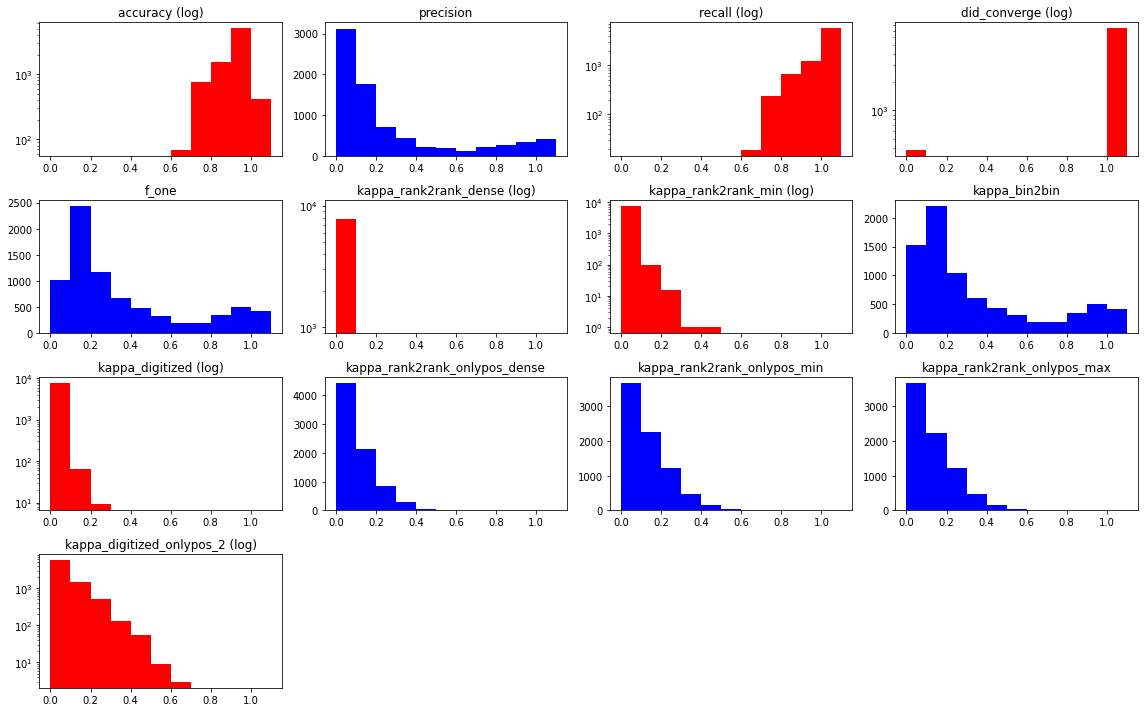

## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 100, dcm_quant_measure: ppmi, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #00ffff">c6de3545d0</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

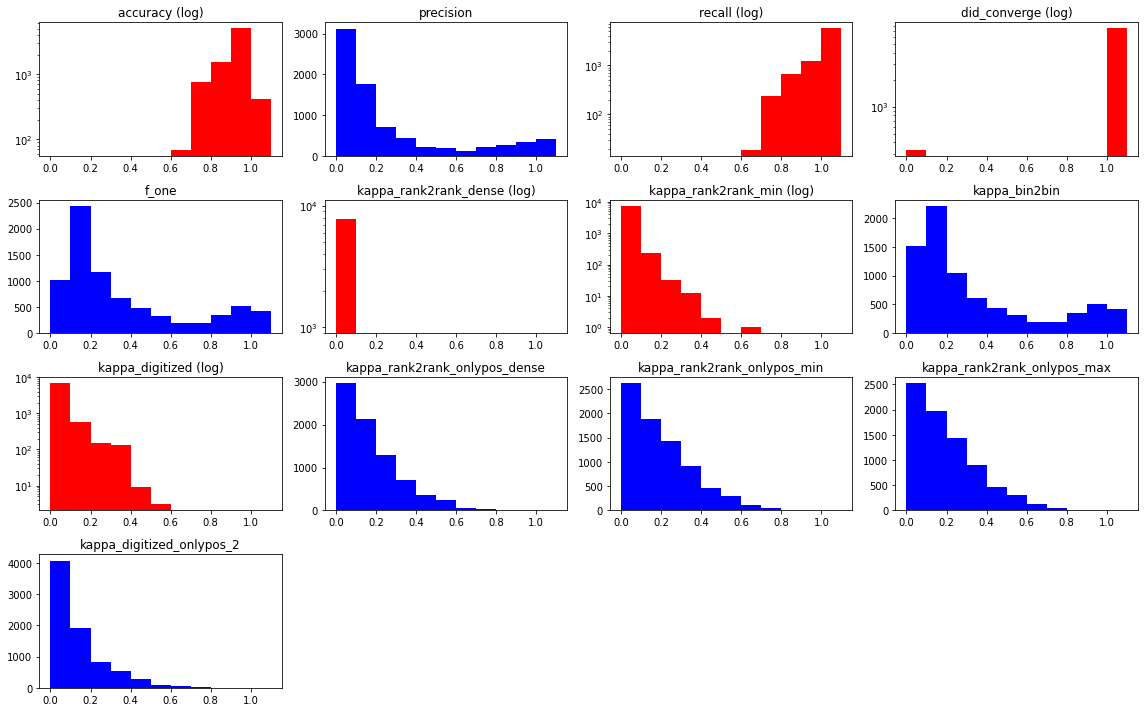

## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 100, dcm_quant_measure: tfidf, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #009999">20033af523</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

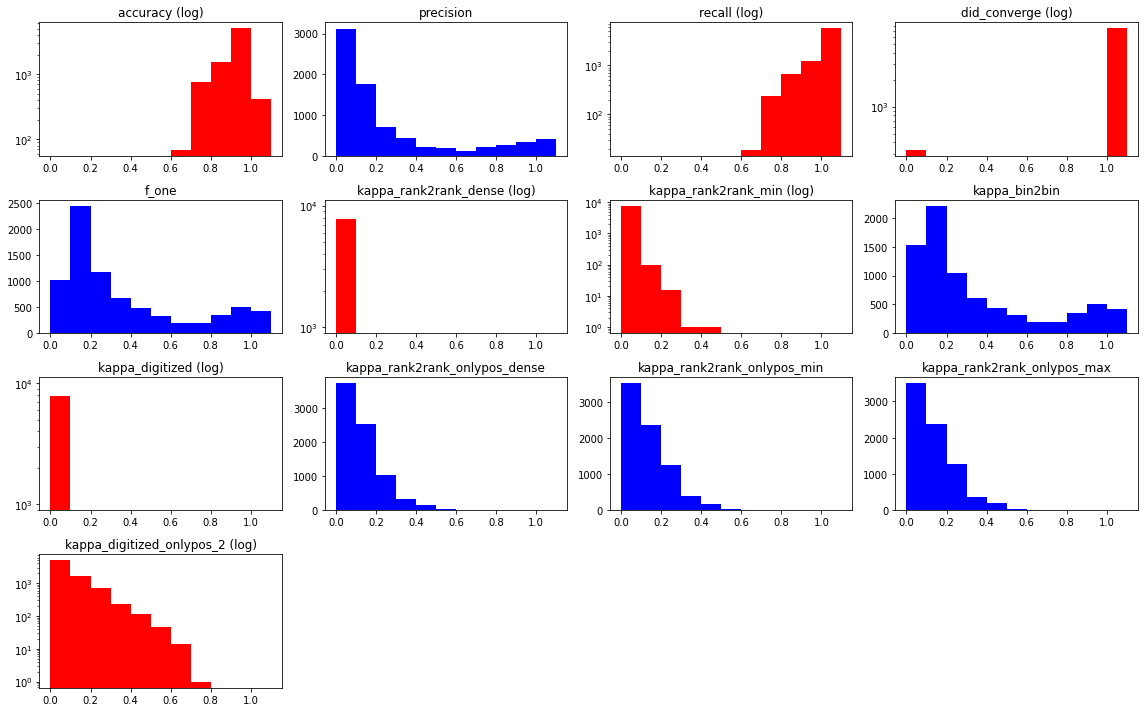

## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 100, dcm_quant_measure: tfidf, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #0000ff">3618e20def</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

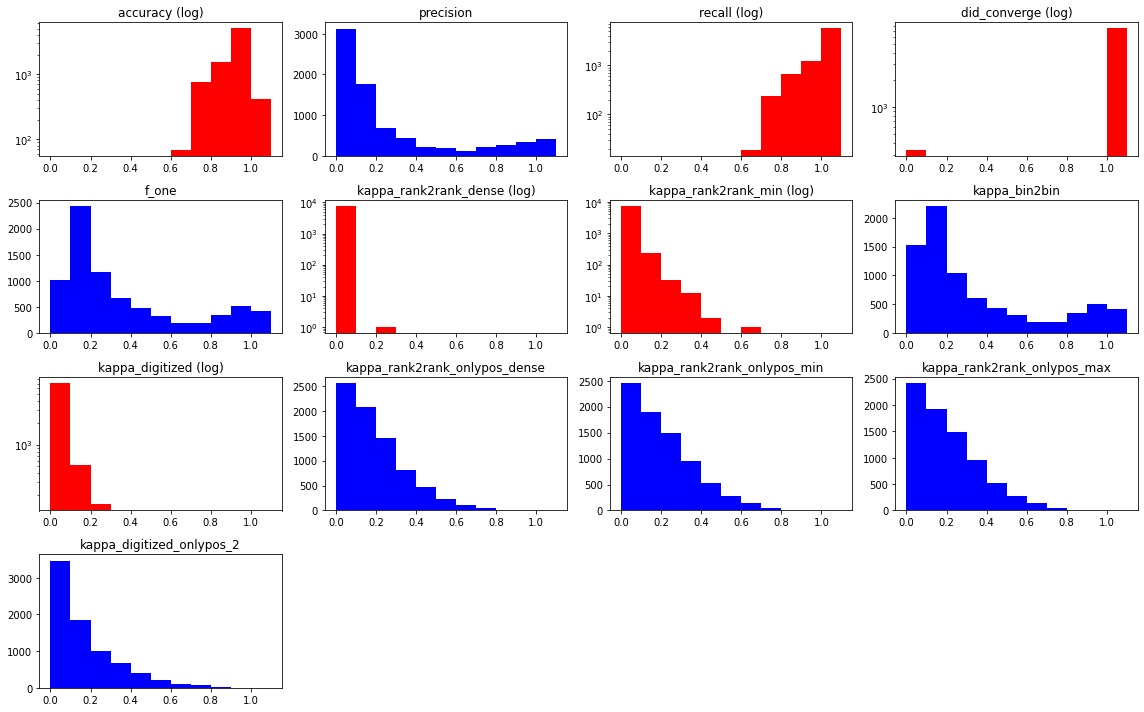

## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 200, dcm_quant_measure: count, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #009999">1a4a4e2ebf</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

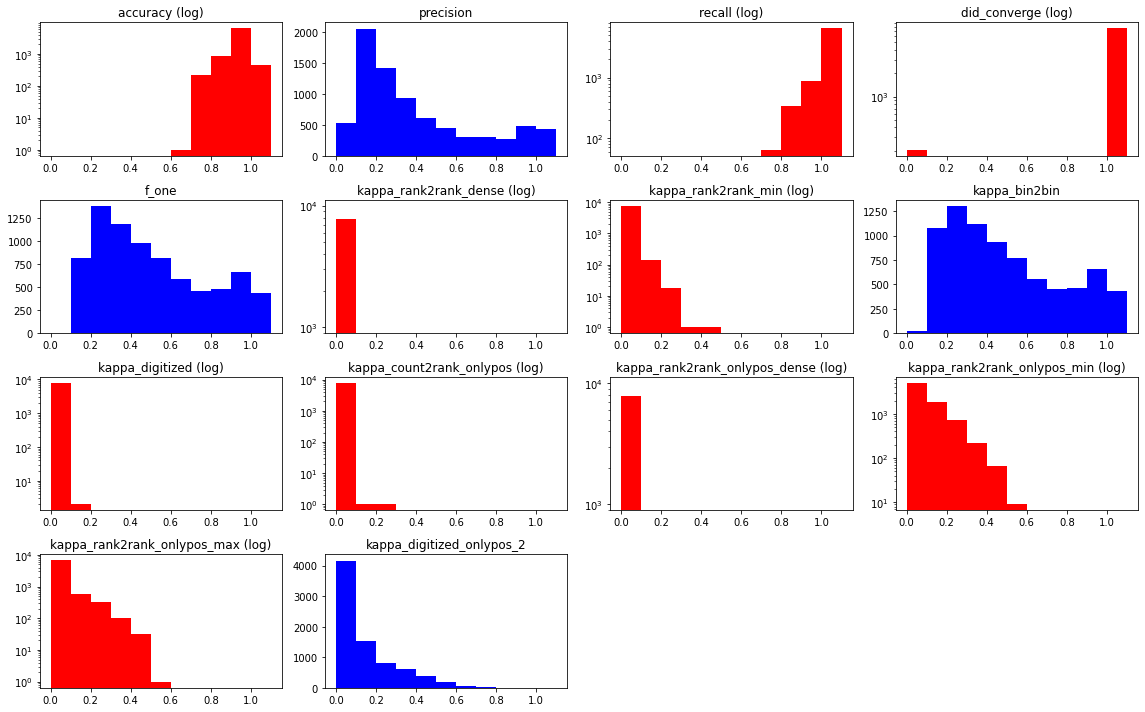

## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 200, dcm_quant_measure: count, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #009999">d25bc818d5</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #0000ff">count</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

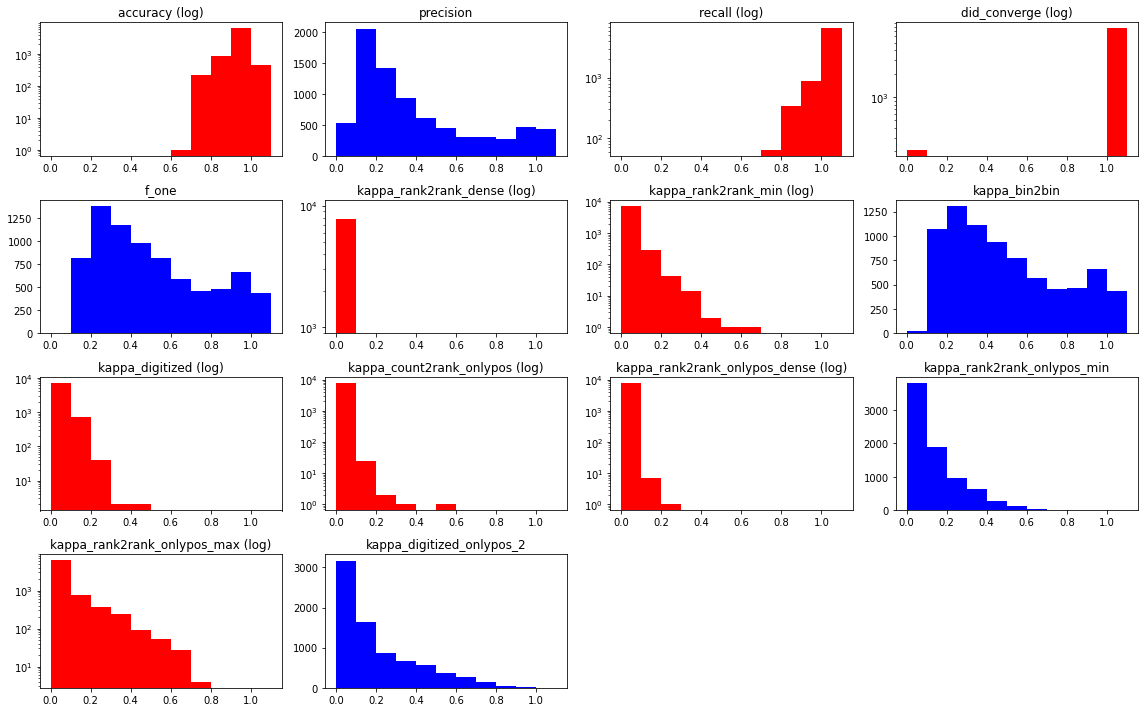

## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 200, dcm_quant_measure: ppmi, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #00ff00">f7fe21c1ce</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

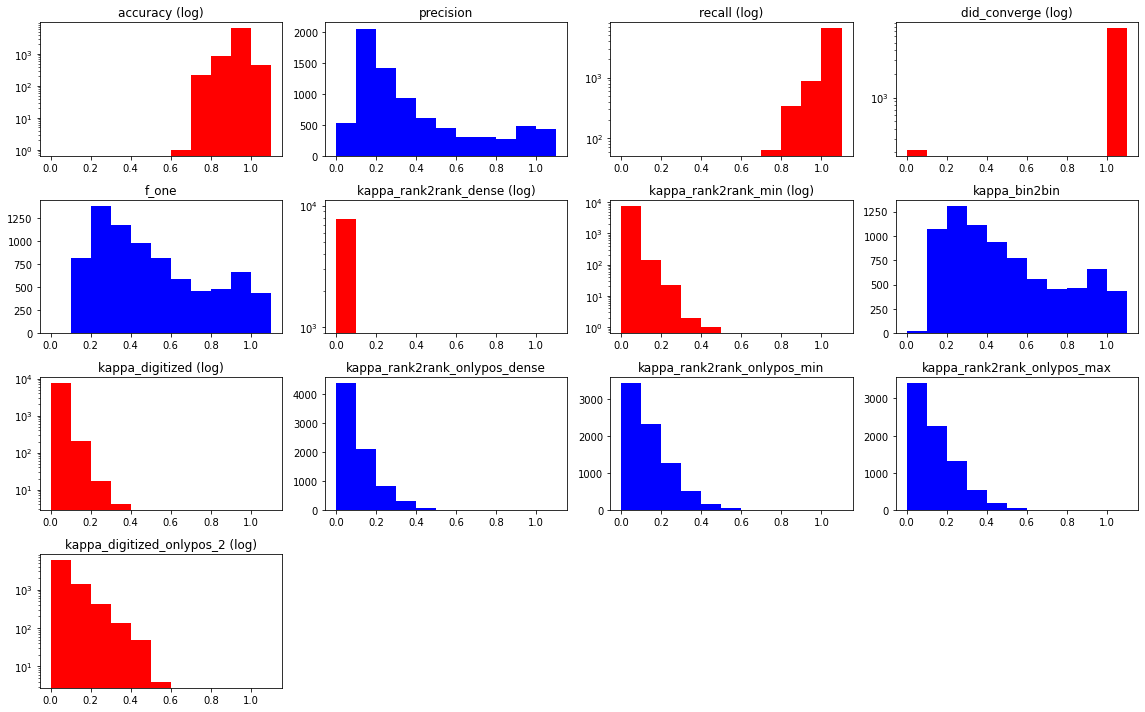

## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 200, dcm_quant_measure: ppmi, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #ffff00">b2fa36c05c</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">ppmi</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

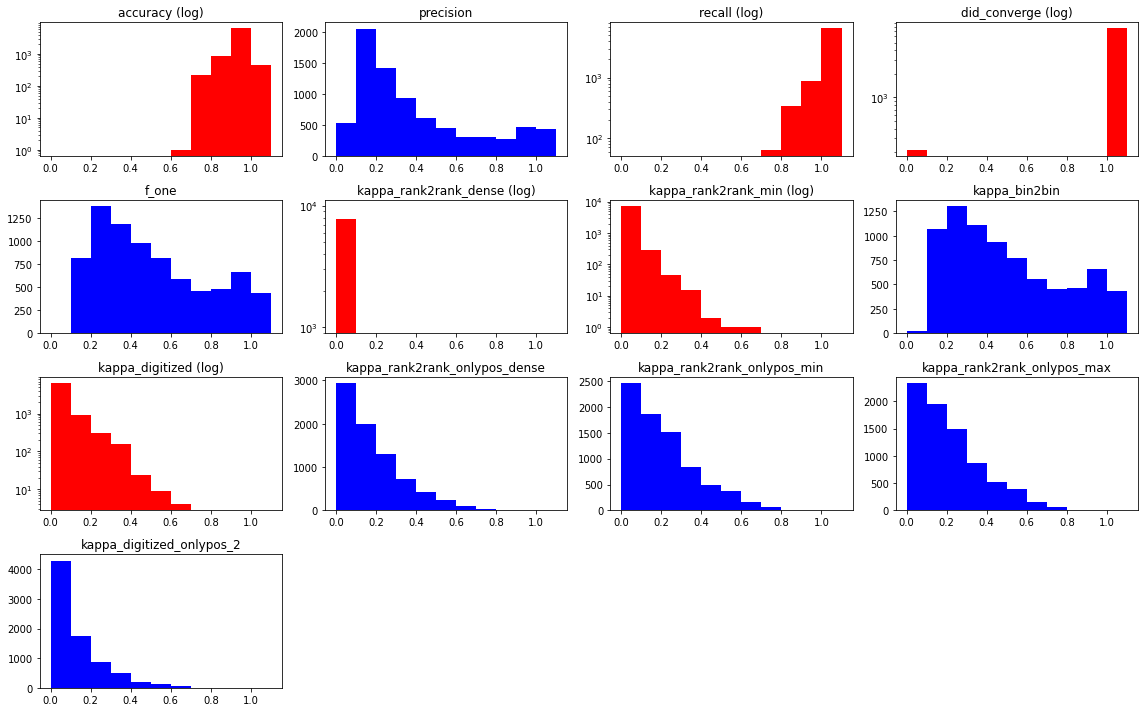

## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 200, dcm_quant_measure: tfidf, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #00ff00">746409b0df</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

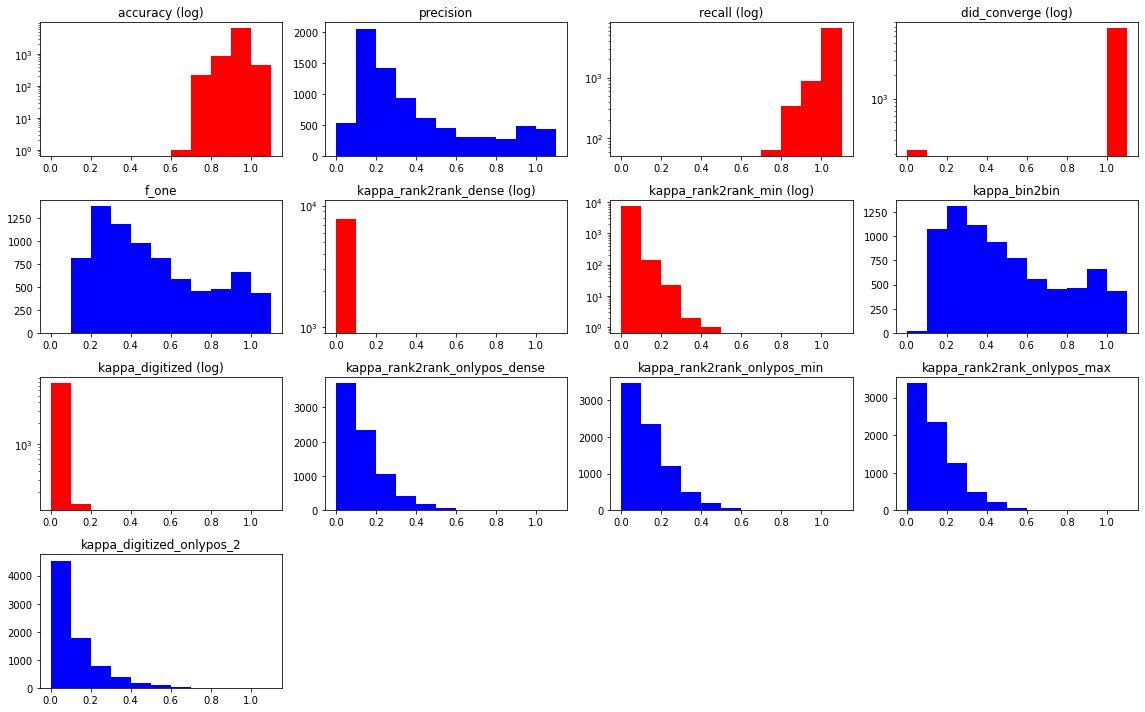

## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 200, dcm_quant_measure: tfidf, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #00ffff">6dd3bf7174</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhcsd2</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

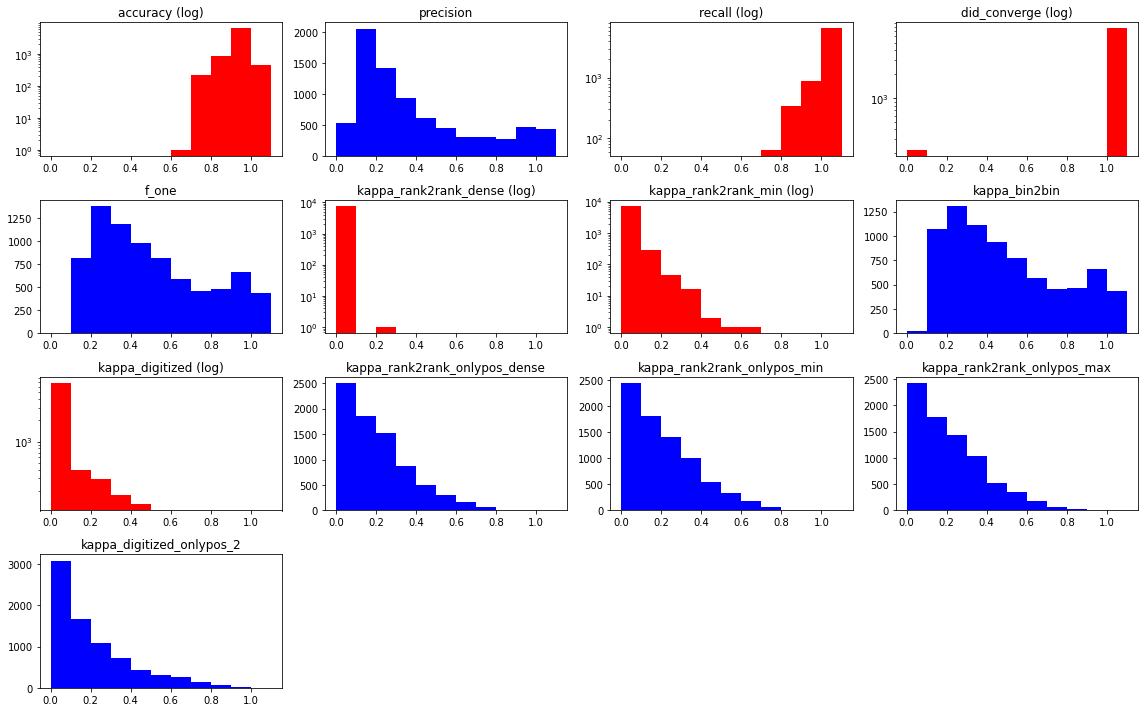

## pp_components: mfauhtcsldp, quantification_measure: count, embed_dimensions: 100, dcm_quant_measure: tfidf, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #009999">f455f59ef1</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhtcsldp</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

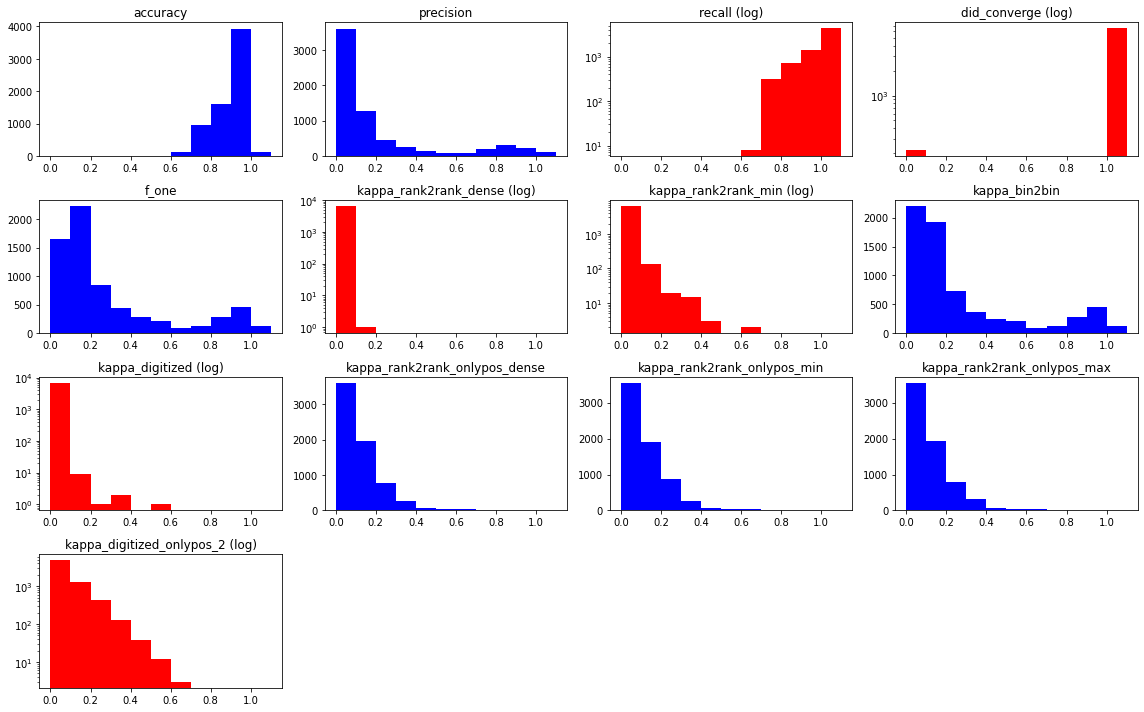

## pp_components: mfauhtcsldp, quantification_measure: count, embed_dimensions: 100, dcm_quant_measure: tfidf, kappa_weights: quadratic

<span style="font-size:11pt">Settings: <span style="color: #ff00ff">56628dd93c</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #0000ff">100</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #0000ff">quadratic</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhtcsldp</span>, QUANTIFICATION_MEASURE: <span style="color: #0000ff">count</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

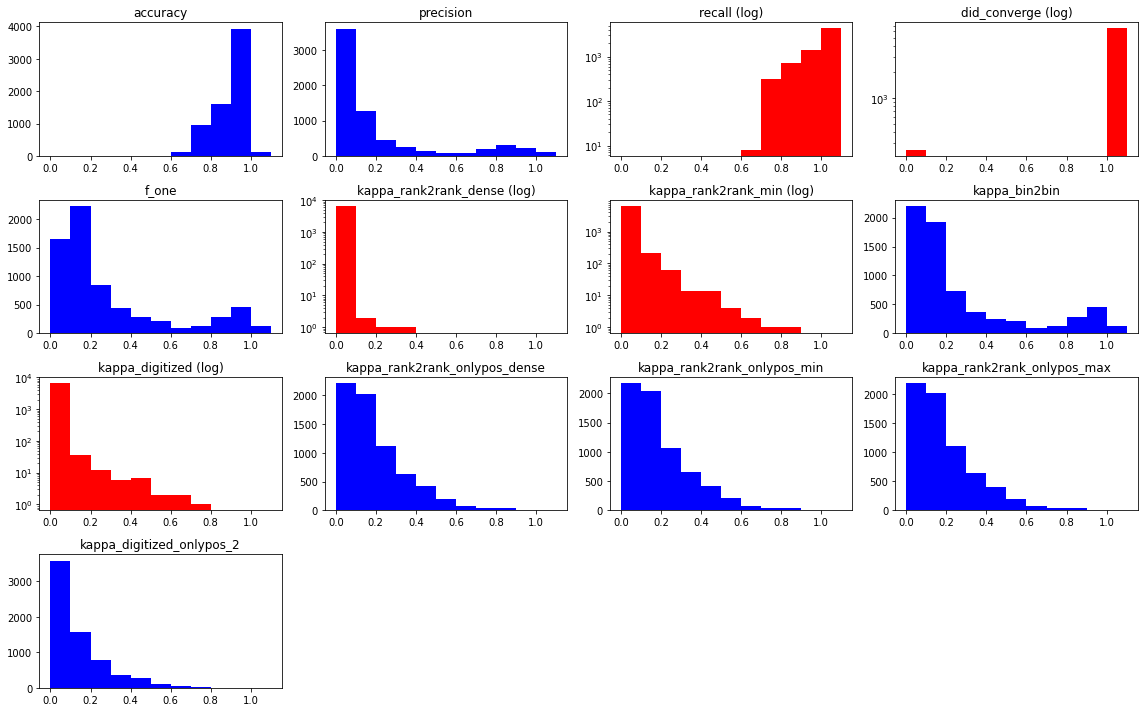

## pp_components: mfauhtcsldp, quantification_measure: tfidf, embed_dimensions: 200, dcm_quant_measure: tfidf, kappa_weights: linear

<span style="font-size:11pt">Settings: <span style="color: #ffff00">9d20f8fd3f</span> - CLASSIFIER: <span style="color: #0000ff">SVM</span>, DATASET: <span style="color: #ff0000">siddata2022</span>, DCM_QUANT_MEASURE: <span style="color: #ff0000">tfidf</span>, DEBUG: <span style="color: #0000ff">False</span>, EMBED_ALGO: <span style="color: #0000ff">mds</span>, EMBED_DIMENSIONS: <span style="color: #ff0000">200</span>, EXTRACTION_METHOD: <span style="color: #ff0000">all</span>, KAPPA_WEIGHTS: <span style="color: #ff0000">linear</span>, LANGUAGE: <span style="color: #0000ff">de</span>, MIN_WORDS_PER_DESC: <span style="color: #ff0000">80</span>, PP_COMPONENTS: <span style="color: #ff0000">mfauhtcsldp</span>, QUANTIFICATION_MEASURE: <span style="color: #ff0000">tfidf</span>, RANDOM_SEED: <span style="color: #ff0000">None</span>, TRANSLATE_POLICY: <span style="color: #0000ff">onlyorig</span></span>

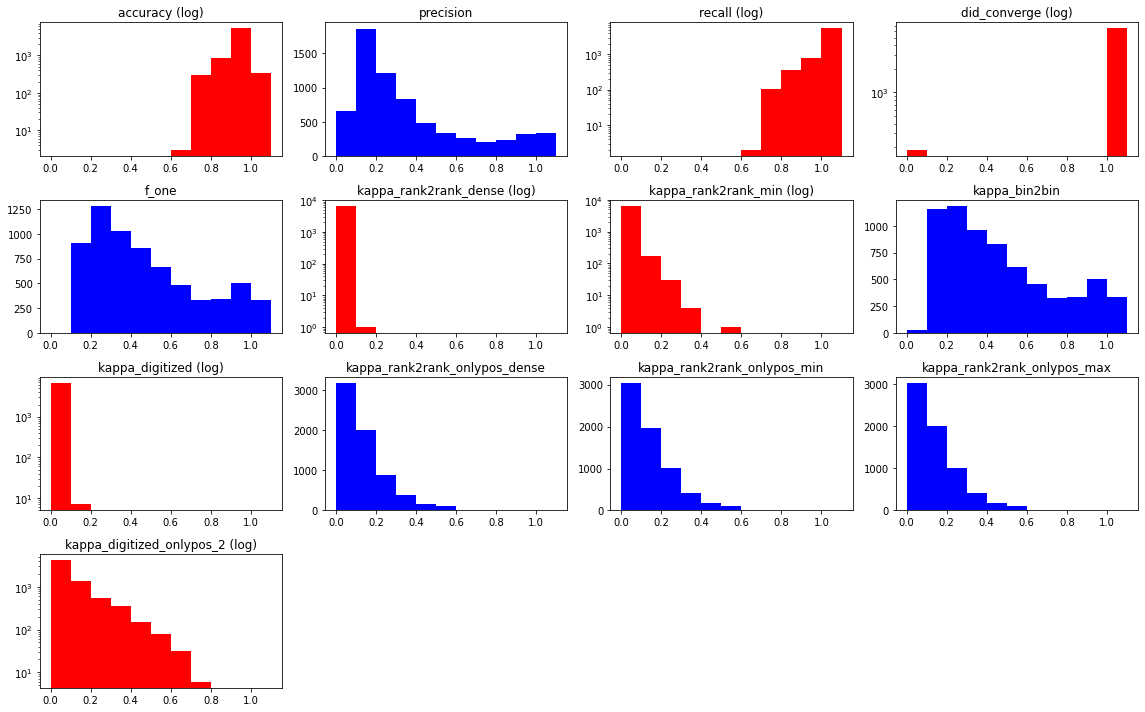

In [5]:
for conf, (important_settings, clusters) in zip(configs, cluster_list):
    specials = {k: v for k, v in conf.items() if isinstance(print_cnf[k], list)}
    display(Markdown("## "+", ".join(f"{k}: {v}" for k,v in specials.items())))
    display("Settings: "+(" - ".join(important_settings)))
    display_metrics(clusters["metrics"])

In [6]:
alls = {}
for conf, (important_settings, clusters) in zip(configs, cluster_list):
    specials = {k: v for k, v in conf.items() if isinstance(print_cnf[k], list)}
    display(Markdown("## "+", ".join(f"{k}: {v}" for k,v in specials.items())))
    #display("Settings:"+(": ".join(important_settings)))
    #show_lambda_elements(clusters["metrics"], 0.5, 0.1)
    lambda1, lambda2 = 0.5, 0.1
    metlist = clusters["metrics"]
    res = {}
    for met in list(list(metlist.values())[0].keys()):
        if "kappa" in met and not "bin2bin" in met:
            vals = [i[met] for i in metlist.values()]
            t1 = len([i for i in vals if i >= lambda1])
            t2 = len([i for i in vals if i >= lambda2]) - t1
            if t1:
                print(f" {met}: T^{lambda1}: {t1}, T^{lambda2}: {t2}, in T^{lambda1}: {', '.join([k for k, v in metlist.items() if v[met] > lambda1][:5])}")
            # res[met] = {lambda1: t1, lambda2: t2, f"{lambda1}_elems": [k for k, v in metlist.items() if v[met] > lambda1][:5]}
            met = met.replace("kappa", "k").replace("dense", "d").replace("rank2rank", "r2r").replace("count2rank", "c2r").replace("bin2bin", "b2b").replace("f_one", "f1").replace("digitized", "dig").replace("_onlypos", "+")
            res[met] = t1
    # alls[" | ".join(f"{v}" for k,v in specials.items())] = res
    alls[tuple(specials.values())] = res

## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 3, dcm_quant_measure: count, kappa_weights: linear

 kappa_rank2rank_onlypos_min: T^0.5: 2, T^0.1: 1069, in T^0.5: bremen, schuldrecht


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 3, dcm_quant_measure: count, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 1, T^0.1: 46, in T^0.5: seminar
 kappa_rank2rank_onlypos_min: T^0.5: 28, T^0.1: 1646, in T^0.5: uni bremen, geschult, stufe, gelande, bgb
 kappa_rank2rank_onlypos_max: T^0.5: 13, T^0.1: 536, in T^0.5: uni bremen, geschult, stufe, gelande, bgb


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 3, dcm_quant_measure: ppmi, kappa_weights: linear

 kappa_rank2rank_onlypos_dense: T^0.5: 9, T^0.1: 2489, in T^0.5: erfolgreichen scheinerwerb, schuldrecht, studierenden gelegenheit, griechen, solide
 kappa_rank2rank_onlypos_min: T^0.5: 30, T^0.1: 3175, in T^0.5: tutorium besucht, zeit 10 00, erfolgreichen scheinerwerb, fachschaft padagogik, schuldrecht
 kappa_rank2rank_onlypos_max: T^0.5: 74, T^0.1: 3159, in T^0.5: hauptteile gegliedert vermittlung, hauptteile gegliedert, themenorientierten hausaufgaben geschult kurs zwei, geographie behandelt, hausaufgaben geschult kurs
 kappa_digitized_onlypos_2: T^0.5: 7, T^0.1: 1735, in T^0.5: seminar beschaftigen, tutorin betreut, selbstrecherche, studierende tutor tutorin, studierende tutor tutorin betreut


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 3, dcm_quant_measure: ppmi, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 1, T^0.1: 48, in T^0.5: seminar
 kappa_rank2rank_onlypos_dense: T^0.5: 145, T^0.1: 3874, in T^0.5: strafrecht, niveau, umfang sws, einbeziehen, 20 uhr
 kappa_rank2rank_onlypos_min: T^0.5: 370, T^0.1: 3913, in T^0.5: strafrecht, lesefahigkeit anhand, einbringen, niveau, hauptteile gegliedert vermittlung
 kappa_rank2rank_onlypos_max: T^0.5: 510, T^0.1: 3741, in T^0.5: strafrecht, lesefahigkeit anhand, einbringen, konfliktsituationen, niveau
 kappa_digitized_onlypos_2: T^0.5: 191, T^0.1: 2988, in T^0.5: hauptteile gegliedert vermittlung, bitte namen laufenden, hauptteile gegliedert, didaktik tutorium, beide veranstaltungen vorlesung tutorium


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 3, dcm_quant_measure: tfidf, kappa_weights: linear

 kappa_rank2rank_onlypos_dense: T^0.5: 5, T^0.1: 2701, in T^0.5: cultural, schuldrecht, erfolgreichen scheinerwerb, studierenden gelegenheit, seminar beschaftigen
 kappa_rank2rank_onlypos_min: T^0.5: 18, T^0.1: 2852, in T^0.5: mittwochs zeit 10 00, cultural, zeit 10 00, erhaltlich fachschaft padagogik ersten, mittwochs zeit 10 00 uhr
 kappa_rank2rank_onlypos_max: T^0.5: 24, T^0.1: 2818, in T^0.5: tutorin betreut mittwochs zeit, mittwochs zeit 10 00, cultural, tutorin betreut mittwochs, zeit 10 00
 kappa_digitized_onlypos_2: T^0.5: 2, T^0.1: 848, in T^0.5: gestalterische, bitte melden tutorien


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 3, dcm_quant_measure: tfidf, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 1, T^0.1: 48, in T^0.5: seminar
 kappa_rank2rank_onlypos_dense: T^0.5: 110, T^0.1: 3589, in T^0.5: gelande, umfang sws, konstellationen, 00 uhr raum, blocks
 kappa_rank2rank_onlypos_min: T^0.5: 237, T^0.1: 3560, in T^0.5: themenorientierten hausaufgaben geschult kurs zwei, padagogik ersten semesterwoche finanziert, 15 uhr erganzt, ende veranstaltung, entspannungstechniken
 kappa_rank2rank_onlypos_max: T^0.5: 278, T^0.1: 3463, in T^0.5: themenorientierten hausaufgaben geschult kurs zwei, padagogik ersten semesterwoche finanziert, 15 uhr erganzt, ende veranstaltung, entspannungstechniken
 kappa_digitized_onlypos_2: T^0.5: 83, T^0.1: 1676, in T^0.5: themenorientierten hausaufgaben geschult kurs zwei, bitte namen laufenden, studierende tutor tutorin betreut, studierenden themenorientierten hausaufgaben geschult, gegliedert vermittlung


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 100, dcm_quant_measure: count, kappa_weights: linear

 kappa_rank2rank_min: T^0.5: 1, T^0.1: 139, in T^0.5: seminar
 kappa_rank2rank_onlypos_min: T^0.5: 3, T^0.1: 2070, in T^0.5: migration, haupt realschule, vorlesung
 kappa_rank2rank_onlypos_max: T^0.5: 1, T^0.1: 766, in T^0.5: vorlesung
 kappa_digitized_onlypos_2: T^0.5: 64, T^0.1: 1981, in T^0.5: japan, globalisierten, runden, 1960, arabisch


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 100, dcm_quant_measure: count, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 5, T^0.1: 273, in T^0.5: sollen, sowie, dabei, veranstaltung, seminar
 kappa_rank2rank_onlypos_min: T^0.5: 114, T^0.1: 2860, in T^0.5: 00, vier semestern, kurs, studierenden, tutorium
 kappa_rank2rank_onlypos_max: T^0.5: 52, T^0.1: 1154, in T^0.5: 00, kurs, tutorium, uni bremen, migration
 kappa_digitized_onlypos_2: T^0.5: 290, T^0.1: 2385, in T^0.5: japan, barth, vier semestern, 15 11, wurzburg


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 100, dcm_quant_measure: ppmi, kappa_weights: linear

 kappa_rank2rank_min: T^0.5: 1, T^0.1: 145, in T^0.5: seminar
 kappa_digitized: T^0.5: 3, T^0.1: 104, in T^0.5: sowie, seminar, veranstaltung
 kappa_rank2rank_onlypos_dense: T^0.5: 5, T^0.1: 1970, in T^0.5: exkursion, musik, wissenschaftlichen arbeit, migration, eu
 kappa_rank2rank_onlypos_min: T^0.5: 44, T^0.1: 2647, in T^0.5: sowie, schule, exkursion, entwicklung, seminar
 kappa_rank2rank_onlypos_max: T^0.5: 46, T^0.1: 2733, in T^0.5: sowie, schule, pro semester, exkursion, entwicklung
 kappa_digitized_onlypos_2: T^0.5: 9, T^0.1: 1400, in T^0.5: schule, musik, arbeit tutorien, philosophie, 00


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 100, dcm_quant_measure: ppmi, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 6, T^0.1: 276, in T^0.5: sowie, seminar, literatur, veranstaltung, sollen
 kappa_digitized: T^0.5: 27, T^0.1: 657, in T^0.5: sowie, uhr, entwicklung, seminar, lernen
 kappa_rank2rank_onlypos_dense: T^0.5: 139, T^0.1: 3029, in T^0.5: berechtigt, strafrecht, ende zweiten, beruflichen bildung, umfang sws
 kappa_rank2rank_onlypos_min: T^0.5: 224, T^0.1: 3291, in T^0.5: berechtigt, strafrecht, ende zweiten, beruflichen bildung, umfang sws
 kappa_rank2rank_onlypos_max: T^0.5: 247, T^0.1: 3308, in T^0.5: berechtigt, strafrecht, ende zweiten, beruflichen bildung, cornelsen
 kappa_digitized_onlypos_2: T^0.5: 120, T^0.1: 2422, in T^0.5: umfang sws, uni osnabrueck, interkulturelle, sowie, uhr


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 100, dcm_quant_measure: tfidf, kappa_weights: linear

 kappa_rank2rank_min: T^0.5: 2, T^0.1: 145, in T^0.5: seminar, sowie
 kappa_digitized: T^0.5: 3, T^0.1: 7, in T^0.5: seminar, sowie, veranstaltung
 kappa_rank2rank_onlypos_dense: T^0.5: 53, T^0.1: 2319, in T^0.5: deutschen, gewalt, sprache, lernen, seminar
 kappa_rank2rank_onlypos_min: T^0.5: 55, T^0.1: 2549, in T^0.5: deutschen, gewalt, sprache, lernen, seminar
 kappa_rank2rank_onlypos_max: T^0.5: 58, T^0.1: 2648, in T^0.5: deutschen, gewalt, kompetenz grundlage, sprache, lernen
 kappa_digitized_onlypos_2: T^0.5: 18, T^0.1: 1864, in T^0.5: arabisch, haupt realschule, stimme, teil veranstaltung, wirtschaftsgeographie


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 100, dcm_quant_measure: tfidf, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 6, T^0.1: 277, in T^0.5: seminar, literatur, dabei, sollen, sowie
 kappa_digitized: T^0.5: 5, T^0.1: 451, in T^0.5: seminar, einfuhrung, sollen, sowie, veranstaltung
 kappa_rank2rank_onlypos_dense: T^0.5: 246, T^0.1: 3146, in T^0.5: center, deutschen, promovierende, hg, ende zweiten
 kappa_rank2rank_onlypos_min: T^0.5: 270, T^0.1: 3095, in T^0.5: entspannungstechniken, center, deutschen, promovierende, hg
 kappa_rank2rank_onlypos_max: T^0.5: 281, T^0.1: 3206, in T^0.5: 15 uhr erganzt, entspannungstechniken, center, deutschen, promovierende
 kappa_digitized_onlypos_2: T^0.5: 201, T^0.1: 2634, in T^0.5: vorgesehen studierende, forschungsfragen, testaments, didaktisches, traditionen


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 200, dcm_quant_measure: count, kappa_weights: linear

 kappa_rank2rank_min: T^0.5: 1, T^0.1: 176, in T^0.5: seminar
 kappa_rank2rank_onlypos_min: T^0.5: 2, T^0.1: 2163, in T^0.5: migration, vorlesung
 kappa_digitized_onlypos_2: T^0.5: 118, T^0.1: 2522, in T^0.5: studierende geographie bern, internationales, verwiesen, zeitgenossen, globalisierten


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 200, dcm_quant_measure: count, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 5, T^0.1: 341, in T^0.5: sollen, sowie, dabei, veranstaltung, seminar
 kappa_digitized: T^0.5: 1, T^0.1: 474, in T^0.5: fragen
 kappa_rank2rank_onlypos_min: T^0.5: 133, T^0.1: 2930, in T^0.5: 00, kurs, studierenden, tutorium, didaktik
 kappa_rank2rank_onlypos_max: T^0.5: 52, T^0.1: 1227, in T^0.5: 00, kurs, tutorium, didaktik, uni bremen
 kappa_digitized_onlypos_2: T^0.5: 509, T^0.1: 2746, in T^0.5: cultural, systeme, global, leben, religion


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 200, dcm_quant_measure: ppmi, kappa_weights: linear

 kappa_rank2rank_min: T^0.5: 1, T^0.1: 184, in T^0.5: seminar
 kappa_digitized: T^0.5: 3, T^0.1: 161, in T^0.5: sowie, seminar, veranstaltung
 kappa_rank2rank_onlypos_dense: T^0.5: 10, T^0.1: 2129, in T^0.5: exkursion, musik, schuldrecht, kunst, philosophie
 kappa_rank2rank_onlypos_min: T^0.5: 66, T^0.1: 2853, in T^0.5: sowie, schule, aufl stuttgart, exkursion, entwicklung
 kappa_rank2rank_onlypos_max: T^0.5: 71, T^0.1: 2929, in T^0.5: sowie, schule, exkursion, entwicklung, hrsg
 kappa_digitized_onlypos_2: T^0.5: 1, T^0.1: 1362, in T^0.5: arbeit tutorien


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 200, dcm_quant_measure: ppmi, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 6, T^0.1: 349, in T^0.5: sowie, seminar, literatur, veranstaltung, sollen
 kappa_digitized: T^0.5: 57, T^0.1: 1005, in T^0.5: sowie, uhr, schule, exkursion, seit
 kappa_rank2rank_onlypos_dense: T^0.5: 196, T^0.1: 3299, in T^0.5: strafrecht, ende zweiten, cornelsen, korper, umfang sws
 kappa_rank2rank_onlypos_min: T^0.5: 315, T^0.1: 3521, in T^0.5: strafrecht, ende zweiten, korper, umfang sws, moglichkeiten
 kappa_rank2rank_onlypos_max: T^0.5: 344, T^0.1: 3541, in T^0.5: romanistik kurs zweisemestrig, strafrecht, ende zweiten, cornelsen, korper
 kappa_digitized_onlypos_2: T^0.5: 90, T^0.1: 2508, in T^0.5: uni osnabrueck, interkulturelle, uhr, schule, pro semester


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 200, dcm_quant_measure: tfidf, kappa_weights: linear

 kappa_rank2rank_min: T^0.5: 2, T^0.1: 183, in T^0.5: seminar, sowie
 kappa_digitized: T^0.5: 2, T^0.1: 40, in T^0.5: sowie, veranstaltung
 kappa_rank2rank_onlypos_dense: T^0.5: 82, T^0.1: 2491, in T^0.5: deutschen, hg, gewalt, auflage, sprache
 kappa_rank2rank_onlypos_min: T^0.5: 88, T^0.1: 2701, in T^0.5: 15 uhr erganzt, deutschen, hg, gewalt, auflage
 kappa_rank2rank_onlypos_max: T^0.5: 89, T^0.1: 2819, in T^0.5: 15 uhr erganzt, deutschen, hg, gewalt, auflage
 kappa_digitized_onlypos_2: T^0.5: 74, T^0.1: 2123, in T^0.5: deutschen, hg, gewalt, reformation, gott


## pp_components: mfauhcsd2, quantification_measure: count, embed_dimensions: 200, dcm_quant_measure: tfidf, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 6, T^0.1: 349, in T^0.5: seminar, literatur, dabei, sollen, sowie
 kappa_digitized: T^0.5: 17, T^0.1: 1033, in T^0.5: seminar, methoden, studierenden, dabei, grundlagen
 kappa_rank2rank_onlypos_dense: T^0.5: 357, T^0.1: 3281, in T^0.5: testaments, lehrer, center, deutschen, hg
 kappa_rank2rank_onlypos_min: T^0.5: 370, T^0.1: 3333, in T^0.5: testaments, 15 uhr erganzt, lehrer, entspannungstechniken, center
 kappa_rank2rank_onlypos_max: T^0.5: 372, T^0.1: 3378, in T^0.5: testaments, 15 uhr erganzt, lehrer, entspannungstechniken, center
 kappa_digitized_onlypos_2: T^0.5: 433, T^0.1: 2762, in T^0.5: ag, testaments, didaktisches, studium, deutschen


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 3, dcm_quant_measure: count, kappa_weights: linear

 kappa_rank2rank_onlypos_min: T^0.5: 1, T^0.1: 1022, in T^0.5: fallstudie


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 3, dcm_quant_measure: count, kappa_weights: quadratic

 kappa_rank2rank_onlypos_min: T^0.5: 18, T^0.1: 1574, in T^0.5: uni bremen, www uni, bremen, html, schulpraktikum
 kappa_rank2rank_onlypos_max: T^0.5: 16, T^0.1: 469, in T^0.5: uni bremen, www uni, html, schulpraktikum, allgemeine schulpraktikum
 kappa_digitized_onlypos_2: T^0.5: 1, T^0.1: 314, in T^0.5: allgemeine schulpraktikum


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 3, dcm_quant_measure: ppmi, kappa_weights: linear

 kappa_rank2rank_onlypos_dense: T^0.5: 7, T^0.1: 2624, in T^0.5: zlb, vorbereitung allgemeine schulpraktikum, allgemeine schulpraktikum, nomos, schulpraktikum
 kappa_rank2rank_onlypos_min: T^0.5: 16, T^0.1: 3137, in T^0.5: uhr bitte melden tutorien, erlautern, zeit 10 00, entwickeln uberprufen erweitern vorlesung einstundig, roth
 kappa_rank2rank_onlypos_max: T^0.5: 30, T^0.1: 3169, in T^0.5: cornelsen, uhr bitte melden tutorien, erlautern, zeit 10 00, munze semesterapparat eingerichtet
 kappa_digitized_onlypos_2: T^0.5: 3, T^0.1: 1947, in T^0.5: vorbereitung allgemeine schulpraktikum, allgemeine schulpraktikum, vorbereitung allgemeine


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 3, dcm_quant_measure: ppmi, kappa_weights: quadratic

 kappa_rank2rank_onlypos_dense: T^0.5: 192, T^0.1: 3641, in T^0.5: de career center veranstaltungen uebersicht, 20 uhr, bremen de career center veranstaltungen, liebe studierende, pro semester
 kappa_rank2rank_onlypos_min: T^0.5: 247, T^0.1: 4027, in T^0.5: cornelsen, de career center veranstaltungen uebersicht, 20 uhr, bremen de career center veranstaltungen, liebe studierende
 kappa_rank2rank_onlypos_max: T^0.5: 363, T^0.1: 3929, in T^0.5: romanistik kurs zweisemestrig, lesefahigkeit anhand, hauptteile gegliedert vermittlung, cornelsen, de career center veranstaltungen uebersicht
 kappa_digitized_onlypos_2: T^0.5: 136, T^0.1: 3260, in T^0.5: konfliktsituationen, erfolgreicher motivierender unterricht, mussen dafur gegeben bzw geschaffen, de career center veranstaltungen uebersicht, bremen de career center veranstaltungen


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 3, dcm_quant_measure: tfidf, kappa_weights: linear

 kappa_rank2rank_onlypos_dense: T^0.5: 10, T^0.1: 2549, in T^0.5: akkusativ, vorbereitung allgemeine schulpraktikum, praktischen beispielen, erlautern, vorbereitung allgemeine
 kappa_rank2rank_onlypos_min: T^0.5: 18, T^0.1: 2714, in T^0.5: uhr bitte melden tutorien, mittwochs zeit 10 00, akkusativ, vorbereitung allgemeine schulpraktikum, entwickeln uberprufen erweitern vorlesung einstundig
 kappa_rank2rank_onlypos_max: T^0.5: 25, T^0.1: 2788, in T^0.5: 10 00 uhr 18 00, uhr bitte melden tutorien, mittwochs zeit 10 00, akkusativ, aufgreifen
 kappa_digitized_onlypos_2: T^0.5: 5, T^0.1: 1139, in T^0.5: klett perthes, vorbereitung allgemeine schulpraktikum, gestalterische, vorbereitung allgemeine, allgemeine schulpraktikum


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 3, dcm_quant_measure: tfidf, kappa_weights: quadratic

 kappa_rank2rank_onlypos_dense: T^0.5: 169, T^0.1: 3626, in T^0.5: ungleichheiten, veranstaltungen html https, gelande, career center veranstaltungen uebersicht, geschlossen bekommen mail
 kappa_rank2rank_onlypos_min: T^0.5: 206, T^0.1: 3693, in T^0.5: padagogik ersten semesterwoche finanziert, ungleichheiten, veranstaltungen html https, tutorin betreut mittwochs zeit, gelande
 kappa_rank2rank_onlypos_max: T^0.5: 217, T^0.1: 3715, in T^0.5: padagogik ersten semesterwoche finanziert, ungleichheiten, veranstaltungen html https, tutorin betreut mittwochs zeit, gelande
 kappa_digitized_onlypos_2: T^0.5: 59, T^0.1: 1865, in T^0.5: erweitern vorlesung einstundig 12 15, sitzung bekannt, klett perthes, erweitern vorlesung einstundig 12, einstundig 12


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 100, dcm_quant_measure: count, kappa_weights: linear

 kappa_rank2rank_onlypos_max: T^0.5: 1, T^0.1: 524, in T^0.5: betreuer
 kappa_digitized_onlypos_2: T^0.5: 47, T^0.1: 1736, in T^0.5: studierende geographie bern, praxisbeispielen, hartmut, leitfaden studierende geographie bern, c1


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 100, dcm_quant_measure: count, kappa_weights: quadratic

 kappa_rank2rank_onlypos_min: T^0.5: 38, T^0.1: 2515, in T^0.5: physische geographie, uni bremen, migration, geschult, ubergreifende
 kappa_rank2rank_onlypos_max: T^0.5: 25, T^0.1: 937, in T^0.5: uni bremen, geschult, ubergreifende, gelande, c1
 kappa_digitized_onlypos_2: T^0.5: 242, T^0.1: 2007, in T^0.5: studienrelevanten spanischen mittelschweren, herzustellen, personal, spanischen mittelschweren, weiterbildung


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 100, dcm_quant_measure: ppmi, kappa_weights: linear

 kappa_rank2rank_onlypos_dense: T^0.5: 2, T^0.1: 2244, in T^0.5: ungefahr, betreuer
 kappa_rank2rank_onlypos_min: T^0.5: 4, T^0.1: 2948, in T^0.5: vo, auseinander setzen, ungefahr, betreuer
 kappa_rank2rank_onlypos_max: T^0.5: 6, T^0.1: 2992, in T^0.5: cornelsen, semester bieten, vo, auseinander setzen, ungefahr
 kappa_digitized_onlypos_2: T^0.5: 1, T^0.1: 1399, in T^0.5: semester bieten


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 100, dcm_quant_measure: ppmi, kappa_weights: quadratic

 kappa_rank2rank_onlypos_dense: T^0.5: 80, T^0.1: 3420, in T^0.5: interkulturelle, reformation, spezifisch, exemplarische inhalte, nennt
 kappa_rank2rank_onlypos_min: T^0.5: 112, T^0.1: 3776, in T^0.5: berechtigt, dinge, interkulturelle, reformation, zweistundiges tutorium 14tagig statt findet
 kappa_rank2rank_onlypos_max: T^0.5: 101, T^0.1: 3845, in T^0.5: berechtigt, dinge, cornelsen, interkulturelle, reformation
 kappa_digitized_onlypos_2: T^0.5: 22, T^0.1: 2855, in T^0.5: interkulturelle, exemplarische, textarbeit, spezifisch, la


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 100, dcm_quant_measure: tfidf, kappa_weights: linear

 kappa_rank2rank_onlypos_dense: T^0.5: 3, T^0.1: 2447, in T^0.5: vo, entsprechenden tutorien, ungefahr
 kappa_rank2rank_onlypos_min: T^0.5: 3, T^0.1: 2672, in T^0.5: vo, entsprechenden tutorien, ungefahr
 kappa_rank2rank_onlypos_max: T^0.5: 5, T^0.1: 2708, in T^0.5: betreuer, semester bieten, vo, entsprechenden tutorien, ungefahr
 kappa_digitized_onlypos_2: T^0.5: 5, T^0.1: 1526, in T^0.5: bertolt brecht, fallstudie, textarbeit, arbeitsmethoden, anschaffen


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 100, dcm_quant_measure: tfidf, kappa_weights: quadratic

 kappa_rank2rank_onlypos_dense: T^0.5: 89, T^0.1: 3628, in T^0.5: gelande, beruflicher, interkulturelles lernen, evangelische theologie, reformation
 kappa_rank2rank_onlypos_min: T^0.5: 90, T^0.1: 3642, in T^0.5: gelande, beruflicher, interkulturelles lernen, reformation, boden
 kappa_rank2rank_onlypos_max: T^0.5: 96, T^0.1: 3822, in T^0.5: gelande, spezifisch, beruflicher, interkulturelles lernen, reformation
 kappa_digitized_onlypos_2: T^0.5: 85, T^0.1: 2779, in T^0.5: europaisierung, pisa, spezifisch, blocks, veranstaltungen vorlesung tutorium


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 200, dcm_quant_measure: count, kappa_weights: linear

 kappa_rank2rank_onlypos_max: T^0.5: 1, T^0.1: 594, in T^0.5: betreuer
 kappa_digitized_onlypos_2: T^0.5: 76, T^0.1: 2244, in T^0.5: cultural, funktionsweise, globalisierten, seminarteilnahme, ndl ndl


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 200, dcm_quant_measure: count, kappa_weights: quadratic

 kappa_rank2rank_onlypos_min: T^0.5: 34, T^0.1: 2576, in T^0.5: physische geographie, uni bremen, migration, geschult, ubergreifende
 kappa_rank2rank_onlypos_max: T^0.5: 21, T^0.1: 988, in T^0.5: tutorium, uni bremen, kunze, geschult, ubergreifende
 kappa_digitized_onlypos_2: T^0.5: 293, T^0.1: 2423, in T^0.5: derzeitigen, cultural, verfugung steht, chemie, weiterbildung


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 200, dcm_quant_measure: ppmi, kappa_weights: linear

 kappa_rank2rank_onlypos_dense: T^0.5: 3, T^0.1: 2438, in T^0.5: 00 uhr raum, php, anschaffen
 kappa_rank2rank_onlypos_min: T^0.5: 4, T^0.1: 3157, in T^0.5: 00 uhr raum, real, php, anschaffen
 kappa_rank2rank_onlypos_max: T^0.5: 4, T^0.1: 3230, in T^0.5: 00 uhr raum, real, php, anschaffen


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 200, dcm_quant_measure: ppmi, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 1, T^0.1: 387, in T^0.5: seminar
 kappa_digitized: T^0.5: 112, T^0.1: 1217, in T^0.5: erfolgreicher motivierender unterricht, mussen dafur gegeben bzw geschaffen, theorien modelle betrachtet, erwachsene generation schulunterricht lasst heute, generation schulunterricht lasst heute
 kappa_rank2rank_onlypos_dense: T^0.5: 100, T^0.1: 3692, in T^0.5: lorenz, mediation, interkulturelle, 00 uhr raum, pro semester
 kappa_rank2rank_onlypos_min: T^0.5: 163, T^0.1: 4013, in T^0.5: mediation, physisch, interkulturelle, 00 uhr raum, einstundig 12
 kappa_rank2rank_onlypos_max: T^0.5: 163, T^0.1: 4083, in T^0.5: mediation, physisch, interkulturelle, 00 uhr raum, anregen eigenen vorstellungen lehren lernen
 kappa_digitized_onlypos_2: T^0.5: 37, T^0.1: 2574, in T^0.5: uni osnabrueck, beide veranstaltungen vorlesung tutorium, pro semester, textarbeit, non


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 200, dcm_quant_measure: tfidf, kappa_weights: linear

 kappa_rank2rank_onlypos_dense: T^0.5: 3, T^0.1: 2790, in T^0.5: starken schwachen, fallstudie, naturwissenschaftliche
 kappa_rank2rank_onlypos_min: T^0.5: 5, T^0.1: 2971, in T^0.5: kunze, starken schwachen, fallstudie, naturwissenschaftliche, textile sachverhalte
 kappa_rank2rank_onlypos_max: T^0.5: 7, T^0.1: 3086, in T^0.5: kunze, starken schwachen, fallstudie, naturwissenschaftliche, entsprechenden tutorien
 kappa_digitized_onlypos_2: T^0.5: 8, T^0.1: 1933, in T^0.5: spezifisch, stimme, wissenschaftlichen arbeit, 10 00uhr, fallstudie


## pp_components: mfauhcsd2, quantification_measure: ppmi, embed_dimensions: 200, dcm_quant_measure: tfidf, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 1, T^0.1: 386, in T^0.5: seminar
 kappa_digitized: T^0.5: 127, T^0.1: 792, in T^0.5: generation schulunterricht, vorlesung stellt ausgewahlte didaktische theorien, mussen sollen schulerinnen, erfolgreicher motivierender unterricht, gegeben vorlesung stellt ausgewahlte didaktische
 kappa_rank2rank_onlypos_dense: T^0.5: 99, T^0.1: 3950, in T^0.5: 00 uhr raum, spezifisch, beruflicher, potential, reformation
 kappa_rank2rank_onlypos_min: T^0.5: 107, T^0.1: 4105, in T^0.5: vorstellungen lehren lernen uberprufen, 00 uhr raum, spezifisch, beruflicher, potential
 kappa_rank2rank_onlypos_max: T^0.5: 106, T^0.1: 4175, in T^0.5: 00 uhr raum, spezifisch, beruflicher, potential, reformation
 kappa_digitized_onlypos_2: T^0.5: 131, T^0.1: 3103, in T^0.5: europaisierung, didaktisches, windows, ende zweiten, 60er


## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 3, dcm_quant_measure: count, kappa_weights: quadratic

 kappa_rank2rank_onlypos_min: T^0.5: 21, T^0.1: 1849, in T^0.5: begleitseminar, hingewiesen, bgb, www uni, bremen
 kappa_rank2rank_onlypos_max: T^0.5: 13, T^0.1: 602, in T^0.5: begleitseminar, www uni, praxisphase, bremen, betreuer
 kappa_digitized_onlypos_2: T^0.5: 1, T^0.1: 437, in T^0.5: ungefahr


## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 3, dcm_quant_measure: ppmi, kappa_weights: linear

 kappa_rank2rank_onlypos_dense: T^0.5: 7, T^0.1: 2773, in T^0.5: 1959, arthur, sprachgebrauch, nomos, interkulturelle kompetenz
 kappa_rank2rank_onlypos_min: T^0.5: 22, T^0.1: 3344, in T^0.5: 1959, zeit 10 00, arthur, zeit 10 00 uhr 18, 15 15 uhr erganzt
 kappa_rank2rank_onlypos_max: T^0.5: 27, T^0.1: 3492, in T^0.5: pro semester, geographie behandelt, 1959, zeit 10 00, arthur
 kappa_digitized_onlypos_2: T^0.5: 2, T^0.1: 1851, in T^0.5: klett perthes, perthes


## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 3, dcm_quant_measure: ppmi, kappa_weights: quadratic

 kappa_rank2rank_onlypos_dense: T^0.5: 229, T^0.1: 3824, in T^0.5: strafrecht, veranstaltungssuche suche vorlesungsverzeichnis, fachubergreifende studienangebote career, fuhlen, de veranstaltungssuche suche vorlesungsverzeichnis fachubergreifende
 kappa_rank2rank_onlypos_min: T^0.5: 357, T^0.1: 4148, in T^0.5: maximal 35, strafrecht, grundschulalter, veranstaltungssuche suche vorlesungsverzeichnis, fachubergreifende studienangebote career
 kappa_rank2rank_onlypos_max: T^0.5: 423, T^0.1: 4156, in T^0.5: maximal 35, strafrecht, hauptteile gegliedert vermittlung, grundschulalter, veranstaltungssuche suche vorlesungsverzeichnis
 kappa_digitized_onlypos_2: T^0.5: 84, T^0.1: 3347, in T^0.5: maximal 35, konfliktsituationen, uberzeugungen, didaktik tutorium, life


## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 3, dcm_quant_measure: tfidf, kappa_weights: linear

 kappa_rank2rank_onlypos_dense: T^0.5: 8, T^0.1: 2816, in T^0.5: blocks, klett perthes, solide, perthes, praxisphase
 kappa_rank2rank_onlypos_min: T^0.5: 22, T^0.1: 3118, in T^0.5: blocks, klett perthes, mittwochs zeit 10 00, solide, 16 00 18
 kappa_rank2rank_onlypos_max: T^0.5: 20, T^0.1: 3186, in T^0.5: blocks, klett perthes, solide, zeit 10 00, hingewiesen
 kappa_digitized_onlypos_2: T^0.5: 3, T^0.1: 789, in T^0.5: klett perthes, gestalterische, perthes


## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 3, dcm_quant_measure: tfidf, kappa_weights: quadratic

 kappa_rank2rank_onlypos_dense: T^0.5: 169, T^0.1: 3804, in T^0.5: befahigen akademischen berufstypischen situationen, ende veranstaltung, entspannungstechniken, center, trier
 kappa_rank2rank_onlypos_min: T^0.5: 255, T^0.1: 3818, in T^0.5: befahigen akademischen berufstypischen situationen, padagogik ersten semesterwoche finanziert, 15 uhr erganzt, ende veranstaltung, entspannungstechniken
 kappa_rank2rank_onlypos_max: T^0.5: 258, T^0.1: 3778, in T^0.5: befahigen akademischen berufstypischen situationen, padagogik ersten semesterwoche finanziert, 15 uhr erganzt, ende veranstaltung, entspannungstechniken
 kappa_digitized_onlypos_2: T^0.5: 24, T^0.1: 1727, in T^0.5: studierende tutor tutorin betreut, klett perthes, konkreten ablauf, gestalterische, didaktik tutorium


## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 100, dcm_quant_measure: count, kappa_weights: linear

 kappa_rank2rank_onlypos_min: T^0.5: 3, T^0.1: 2550, in T^0.5: migration, bremen, sport
 kappa_rank2rank_onlypos_max: T^0.5: 2, T^0.1: 906, in T^0.5: betreuer, strafrecht
 kappa_digitized_onlypos_2: T^0.5: 131, T^0.1: 2382, in T^0.5: weiterbildung, mythos, barth, anna, anfanger


## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 100, dcm_quant_measure: count, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 1, T^0.1: 268, in T^0.5: seminar
 kappa_rank2rank_onlypos_min: T^0.5: 162, T^0.1: 3365, in T^0.5: 00, link http, weiterbildung, kurs, studierenden
 kappa_rank2rank_onlypos_max: T^0.5: 64, T^0.1: 1330, in T^0.5: 00, kurs, tutorium, uni bremen, migration
 kappa_digitized_onlypos_2: T^0.5: 450, T^0.1: 2839, in T^0.5: fontane, religionsunterrichts, chemie, japan, link http


## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 100, dcm_quant_measure: ppmi, kappa_weights: linear

 kappa_rank2rank_onlypos_dense: T^0.5: 20, T^0.1: 2614, in T^0.5: mediation, interkulturelle, exkursion, block, musik
 kappa_rank2rank_onlypos_min: T^0.5: 41, T^0.1: 3116, in T^0.5: mediation, interkulturelle, schule, reformation, exkursion
 kappa_rank2rank_onlypos_max: T^0.5: 56, T^0.1: 3141, in T^0.5: mediation, interkulturelle, schule, reformation, exkursion
 kappa_digitized_onlypos_2: T^0.5: 12, T^0.1: 1817, in T^0.5: schule, block, musik, ubung, stimme


## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 100, dcm_quant_measure: ppmi, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 1, T^0.1: 275, in T^0.5: seminar
 kappa_digitized: T^0.5: 3, T^0.1: 863, in T^0.5: schule, de, vorlesung
 kappa_rank2rank_onlypos_dense: T^0.5: 324, T^0.1: 3340, in T^0.5: berechtigt, strafrecht, niveau, beruflichen bildung, veranstaltungssuche suche vorlesungsverzeichnis
 kappa_rank2rank_onlypos_min: T^0.5: 404, T^0.1: 3441, in T^0.5: berechtigt, strafrecht, niveau, beruflichen bildung, veranstaltungssuche suche vorlesungsverzeichnis
 kappa_rank2rank_onlypos_max: T^0.5: 423, T^0.1: 3559, in T^0.5: berechtigt, strafrecht, niveau, beruflichen bildung, veranstaltungssuche suche vorlesungsverzeichnis
 kappa_digitized_onlypos_2: T^0.5: 151, T^0.1: 2888, in T^0.5: strafrecht, niveau, evaluation, uni osnabrueck, tutorium besucht


## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 100, dcm_quant_measure: tfidf, kappa_weights: linear

 kappa_rank2rank_onlypos_dense: T^0.5: 47, T^0.1: 3037, in T^0.5: center, gewalt, sprache, reformation, besuch vorlesung
 kappa_rank2rank_onlypos_min: T^0.5: 51, T^0.1: 3190, in T^0.5: center, gewalt, sprache, reformation, besuch vorlesung
 kappa_rank2rank_onlypos_max: T^0.5: 53, T^0.1: 3232, in T^0.5: center, gewalt, sprache, reformation, besuch vorlesung
 kappa_digitized_onlypos_2: T^0.5: 61, T^0.1: 2335, in T^0.5: vorlage, business, reformation, demokratie, europarecht


## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 100, dcm_quant_measure: tfidf, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 1, T^0.1: 275, in T^0.5: seminar
 kappa_rank2rank_onlypos_dense: T^0.5: 390, T^0.1: 3557, in T^0.5: lehrer, center, antisemitismus, windows, deutschen
 kappa_rank2rank_onlypos_min: T^0.5: 422, T^0.1: 3578, in T^0.5: 15 uhr erganzt, lehrer, center, antisemitismus, windows
 kappa_rank2rank_onlypos_max: T^0.5: 437, T^0.1: 3626, in T^0.5: 15 uhr erganzt, lehrer, center, antisemitismus, windows
 kappa_digitized_onlypos_2: T^0.5: 425, T^0.1: 3081, in T^0.5: forschungsfragen, europaisierung, didaktisches, antisemitismus, test


## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 200, dcm_quant_measure: count, kappa_weights: linear

 kappa_rank2rank_onlypos_min: T^0.5: 9, T^0.1: 2694, in T^0.5: migration, exkursion, bremen, sachunterricht, schuldrecht
 kappa_rank2rank_onlypos_max: T^0.5: 1, T^0.1: 1063, in T^0.5: schuldrecht
 kappa_digitized_onlypos_2: T^0.5: 281, T^0.1: 3032, in T^0.5: religionsunterrichts, prozesses, chemie, 20 seiten, studierende geographie bern


## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 200, dcm_quant_measure: count, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 2, T^0.1: 339, in T^0.5: veranstaltung, seminar
 kappa_count2rank_onlypos: T^0.5: 1, T^0.1: 27, in T^0.5: schuldrecht
 kappa_rank2rank_onlypos_min: T^0.5: 211, T^0.1: 3500, in T^0.5: romischen, 00, barth, technik, kurs
 kappa_rank2rank_onlypos_max: T^0.5: 83, T^0.1: 1453, in T^0.5: 00, kurs, tutorium, didaktik, uni bremen
 kappa_digitized_onlypos_2: T^0.5: 869, T^0.1: 3200, in T^0.5: systeme, fontane, global, zentrum stehen, religionsunterrichts


## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 200, dcm_quant_measure: ppmi, kappa_weights: linear

 kappa_rank2rank_onlypos_dense: T^0.5: 34, T^0.1: 2695, in T^0.5: interkulturelle, pro semester, aufl stuttgart, exkursion, block
 kappa_rank2rank_onlypos_min: T^0.5: 73, T^0.1: 3492, in T^0.5: korper, interkulturelle, schule, pro semester, reformation
 kappa_rank2rank_onlypos_max: T^0.5: 76, T^0.1: 3550, in T^0.5: korper, schulpraktischen, interkulturelle, schule, pro semester
 kappa_digitized_onlypos_2: T^0.5: 2, T^0.1: 1745, in T^0.5: arbeit tutorien, coaching


## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 200, dcm_quant_measure: ppmi, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 2, T^0.1: 348, in T^0.5: seminar, veranstaltung
 kappa_digitized: T^0.5: 13, T^0.1: 1387, in T^0.5: uhr, schule, literatur, geschichte, texte
 kappa_rank2rank_onlypos_dense: T^0.5: 395, T^0.1: 3518, in T^0.5: strafrecht, ende zweiten, niveau, kafka, veranstaltungssuche suche vorlesungsverzeichnis
 kappa_rank2rank_onlypos_min: T^0.5: 559, T^0.1: 3694, in T^0.5: strafrecht, ende zweiten, fragen allgemeine didaktik seit didactica, niveau, kafka
 kappa_rank2rank_onlypos_max: T^0.5: 577, T^0.1: 3849, in T^0.5: strafrecht, ende zweiten, fragen allgemeine didaktik seit didactica, niveau, kafka
 kappa_digitized_onlypos_2: T^0.5: 153, T^0.1: 2826, in T^0.5: strafrecht, niveau, veranstaltungssuche suche vorlesungsverzeichnis, fachubergreifende studienangebote career, de veranstaltungssuche suche vorlesungsverzeichnis fachubergreifende


## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 200, dcm_quant_measure: tfidf, kappa_weights: linear

 kappa_rank2rank_onlypos_dense: T^0.5: 84, T^0.1: 3248, in T^0.5: gewalt, auflage, interkulturelles lernen, sprache, heinrich
 kappa_rank2rank_onlypos_min: T^0.5: 90, T^0.1: 3464, in T^0.5: gewalt, auflage, interkulturelles lernen, sprache, heinrich
 kappa_rank2rank_onlypos_max: T^0.5: 93, T^0.1: 3565, in T^0.5: gewalt, auflage, interkulturelles lernen, sprache, heinrich
 kappa_digitized_onlypos_2: T^0.5: 144, T^0.1: 2722, in T^0.5: hermeneutik, pisa, psychologie, gewalt, spanischen


## pp_components: mfauhcsd2, quantification_measure: tfidf, embed_dimensions: 200, dcm_quant_measure: tfidf, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 2, T^0.1: 348, in T^0.5: seminar, veranstaltung
 kappa_rank2rank_onlypos_dense: T^0.5: 531, T^0.1: 3757, in T^0.5: hermeneutik, anmeldung studip, didaktisches, lehrer, center
 kappa_rank2rank_onlypos_min: T^0.5: 554, T^0.1: 3760, in T^0.5: hermeneutik, 15 uhr erganzt, anmeldung studip, didaktisches, lehrer
 kappa_rank2rank_onlypos_max: T^0.5: 572, T^0.1: 3793, in T^0.5: hermeneutik, 15 uhr erganzt, anmeldung studip, didaktisches, lehrer
 kappa_digitized_onlypos_2: T^0.5: 794, T^0.1: 3181, in T^0.5: burgerlichen, forschungsfragen, hermeneutik, ru, romische


## pp_components: mfauhtcsldp, quantification_measure: count, embed_dimensions: 100, dcm_quant_measure: tfidf, kappa_weights: linear

 kappa_rank2rank_min: T^0.5: 2, T^0.1: 175, in T^0.5: sollen, seminar
 kappa_digitized: T^0.5: 1, T^0.1: 12, in T^0.5: seminar
 kappa_rank2rank_onlypos_dense: T^0.5: 77, T^0.1: 2114, in T^0.5: https veranstaltungssuche suchen vorlesungsverzeichnis fachubergreifend, sollen, kurs, methode, innen
 kappa_rank2rank_onlypos_min: T^0.5: 79, T^0.1: 2131, in T^0.5: https veranstaltungssuche suchen vorlesungsverzeichnis fachubergreifend, sollen, kurs, methode, medium
 kappa_rank2rank_onlypos_max: T^0.5: 79, T^0.1: 2138, in T^0.5: https veranstaltungssuche suchen vorlesungsverzeichnis fachubergreifend, sollen, kurs, methode, medium
 kappa_digitized_onlypos_2: T^0.5: 15, T^0.1: 1389, in T^0.5: stress, sollen, sozial, neu, arbeit tutorien


## pp_components: mfauhtcsldp, quantification_measure: count, embed_dimensions: 100, dcm_quant_measure: tfidf, kappa_weights: quadratic

 kappa_rank2rank_min: T^0.5: 8, T^0.1: 304, in T^0.5: sollen, seminar, sowie, 2, studierend
 kappa_digitized: T^0.5: 5, T^0.1: 62, in T^0.5: sollen, neu, seminar, studierend, veranstaltung
 kappa_rank2rank_onlypos_dense: T^0.5: 253, T^0.1: 2865, in T^0.5: detailliert information, stress, https veranstaltungssuche suchen vorlesungsverzeichnis fachubergreifend, musik, jahr
 kappa_rank2rank_onlypos_min: T^0.5: 255, T^0.1: 2872, in T^0.5: detailliert information, stress, https veranstaltungssuche suchen vorlesungsverzeichnis fachubergreifend, musik, jahr
 kappa_rank2rank_onlypos_max: T^0.5: 255, T^0.1: 2874, in T^0.5: detailliert information, stress, https veranstaltungssuche suchen vorlesungsverzeichnis fachubergreifend, musik, jahr
 kappa_digitized_onlypos_2: T^0.5: 168, T^0.1: 2089, in T^0.5: detailliert information, stress, https veranstaltungssuche suchen vorlesungsverzeichnis fachubergreifend, karte, 06


## pp_components: mfauhtcsldp, quantification_measure: tfidf, embed_dimensions: 200, dcm_quant_measure: tfidf, kappa_weights: linear

 kappa_rank2rank_min: T^0.5: 1, T^0.1: 209, in T^0.5: seminar
 kappa_rank2rank_onlypos_dense: T^0.5: 121, T^0.1: 2680, in T^0.5: https veranstaltungssuche suchen vorlesungsverzeichnis fachubergreifend, musik, jugend, journalistisch, sport
 kappa_rank2rank_onlypos_min: T^0.5: 120, T^0.1: 2780, in T^0.5: https veranstaltungssuche suchen vorlesungsverzeichnis fachubergreifend, musik, jugend, journalistisch, sport
 kappa_rank2rank_onlypos_max: T^0.5: 120, T^0.1: 2806, in T^0.5: https veranstaltungssuche suchen vorlesungsverzeichnis fachubergreifend, musik, jugend, journalistisch, sport
 kappa_digitized_onlypos_2: T^0.5: 115, T^0.1: 2177, in T^0.5: stress, musik, wolfram, jugend, gluck


In [7]:
styles = [{'selector': 'th', 'props': [('vertical-align','top')]}]  #('border-style', 'solid')  #see https://stackoverflow.com/a/55904239/5122790

df = pd.DataFrame(alls, columns=pd.MultiIndex.from_tuples(alls.keys(), names=list(specials.keys()))).T
df["mean"] = df.mean(axis=1)
df.style.apply(highlight_nonzero_max, axis=0).format(precision=0).set_table_styles(styles)

### Take-Aways from this huge table:
* assuming I want >= 400 directions, I must choose quadratic kappa-weights over linear ones.
* dcm_quant_measure == count is very good for digitized kappa, but consistently a lot worse than tf-idf and ppmi for ranking-based (which makes sense assuming there are many count==1 cases)
* I should go for 3 dimensions only sporadically, but for dcm_quant_measure in [tf-idf, ppmi] it's performance is actually consistently competative (huge surprise!!)

In [12]:
less = {k: v for k, v in alls.items() if k[-1] == "quadratic" and not (k[2] == "3" and k[3] not in ["tfidf", "ppmi"])}
df = pd.DataFrame(less, columns=pd.MultiIndex.from_tuples(less.keys(), names=list(specials.keys()))).T
df["mean"] = df.mean(axis=1)
df.style.apply(highlight_nonzero_max, axis=0).format(precision=0).set_table_styles(styles)

### More analysis:
* quantification_measure == tfidf, n_dims = 200 produces aaaall the best results
* can't really say that results are better if quantification_measure and dcm_quant_measure are the same vs one tf-idf one ppmi